# Lab 2: Classification

Authors: David Shaw, Philip Hale, Kay Ayala, Rikel Djoko

![](https://unitedwaynca.org/wp-content/uploads/2019/04/Census-2020-0411.png)



## Data Preparation Part 1

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [3]:
# Data Processing
import pandas as pd

# modeling tools
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats

# Data Visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

# Utilities
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

## Data Preparation Part 2

Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [4]:
def svm_perprocessing():
    # import original dataset
    df = pd.read_csv("./data/cleanedAdultCensus.csv")

    #  consolidate capital gain/loss into a single net metric.
    df['netCapital'] = df['capitalGain']  - df['capitalLoss']

    # create new variable categorizes worked hours per week
    df.loc[df.hoursPerWeek > 40, "workhrs_"] = "overtime"
    df.loc[(df.hoursPerWeek <= 40) & (df.hoursPerWeek >= 30), "workhrs_"] = "fulltime"
    df.loc[(df.hoursPerWeek < 30 ) & (df.hoursPerWeek >= 20), "workhrs_"] = "partime"
    df.loc[df.hoursPerWeek < 20, "workhrs_"] = "limited"

    #maritalStatus_old = {'Widowed': 'separate', 'Divorced': 'separate', 'Separated': 'separate', 'Never-married': 'single', 'Married-civ-spouse': 'married', 'Married-spouse-absent': 'a_other', 'Married-AF-spouse': 'a_other'}
    #maritalStatus_ = {'Widowed': 'single', 'Divorced': 'single', 'Separated': 'single', 'Never-married': 'single', 'Married-civ-spouse': 'married', 'Married-spouse-absent': 'a_other', 'Married-AF-spouse': 'a_other'}
    #df['maritalStatus_'] = df.maritalStatus.map(lambda x: maritalStatus_[x])

    # compute the nearest 10 for person's decade birth
    #df['age_decade'] = (df.age // 10) * 10

    # one-hot encode `income` and race and maritalStatus, relationship, nativeCountry
    df.loc[df.income == "<=50K", 'income'] = 0 
    df.loc[df.income == ">50K", 'income'] = 1

    df.loc[df.race == "White", 'isWhite'] = 1
    df.loc[df.race != "White", 'isWhite'] = 0

    df.loc[df.maritalStatus == 'Married-AF-spouse', 'isMarried'] = 1
    df.loc[df.maritalStatus != 'Married-AF-spouse', 'isMarried'] = 0

    df.loc[df.relationship == 'Husband', 'isHusband'] = 1
    df.loc[df.relationship != 'Husband', 'isHusband'] = 0

    df.loc[df.nativeCountry == 'United-States', 'USA'] = 1
    df.loc[df.nativeCountry != 'United-States', 'USA'] = 0


    # drop unneeded columns
    #'educationNum','hoursPerWeek',
    unneeded_columns = ['workclass', 'education', 'maritalStatus','race',
                        'occupation', 'capitalGain', 'capitalLoss', 'nativeCountry', 'relationship',
                       'education_','workhrs_']
    df.drop(unneeded_columns, axis=1, inplace=True)



    categorical_variables =  ['sex', 'jobtype' ]
    for var in categorical_variables:
        category_list = 'var'+'_'+var
        category_list = pd.get_dummies(df[var], prefix=var, drop_first=True)
        _temp = df.join(category_list)
        df = _temp


    df.drop(categorical_variables, axis=1, inplace=True)
    #df.head()

    # list of all possible variables
    variables_ = df.columns.values.tolist()
    #variables_ = corr_matrix.index.tolist()
    variables_.remove("income")
    
    return df, variables_

In [5]:
df, variables_ = svm_perprocessing()
#df.to_csv("./data/lab2_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age                   32561 non-null int64
fnlwgt                32561 non-null int64
educationNum          32561 non-null int64
hoursPerWeek          32561 non-null int64
income                32561 non-null int64
netCapital            32561 non-null int64
isWhite               32561 non-null float64
isMarried             32561 non-null float64
isHusband             32561 non-null float64
USA                   32561 non-null float64
sex_Male              32561 non-null uint8
jobtype_government    32561 non-null uint8
jobtype_other         32561 non-null uint8
jobtype_private       32561 non-null uint8
dtypes: float64(4), int64(6), uint8(4)
memory usage: 2.6 MB


In [6]:
print("List of all posible variables")
print(variables_)

# define variables for classificaiton training
y=df['income']
X=df[variables_]

print("")
print("Summary Statistics for the Response Variable: `INCOME`")
print("Average Income (Mean):  {:.3f}".format(y.mean()))
print("Standard Deviation Income:  {:.3f}".format(y.std()))
print("Mim Income:  {:.3f}".format(y.min()))
print("Max Income:  {:.3f}".format(y.max()))

List of all posible variables
['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'sex_Male', 'jobtype_government', 'jobtype_other', 'jobtype_private']

Summary Statistics for the Response Variable: `INCOME`
Average Income (Mean):  0.241
Standard Deviation Income:  0.428
Mim Income:  0.000
Max Income:  1.000


Here we have our data preparation step. We have reduced the full exploration and adjustment of the data to this section. We have dropped 'unneeded columns' above because they had high collinearity. Of the remaining variables, the categorical variables have been all one hot encoded except educationNum. The continuous variables have been untouched. When we do our analysis later the variables will be scaled to reduce scale bias. 

We should note income >50k is our majority class. It constitutes ~75% of our data. 

## Modeling and Evaluation 1

Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

----
### Evaluating Test Performance with ROC Curves

When evaluating the models scored off of the ROC Curves, we are interested in understanding that the best classification has the largest area under the curve. As described by Alaa tharwat in [Classification_Assessment_Methods_a_detailed_tutorial](https://www.researchgate.net/publication/327148996_Classification_Assessment_Methods_a_detailed_tutorial), 

> The __receiver operating characteristics (ROC) curve__ is a twodimensional graph in which the TPR represents the y-axis and FPR is the x-axis.  It is used to make a balance between the benefits, i.e., true positives, and costs, i.e., false positives. Any classifier that has discrete outputs such as decision trees is designed to produce only a class decision, i.e., a decision for each testing sample, and hence it generates only one confusion matrix which in turn corresponds to one point into the ROC space. However, there are many methods that were introduced for generating full ROC curve from a classifier instead of only a single point such as using class proportions or using some combinations of scoring and voting. 

![](./media/ROC_curve_explained.jpg)

> The Above figure shows shows an example of the ROC curve. As shown, there are four important points in the ROC curve. The point A, in the lower left corner (0,0) represents a classifier where there is no positive classification, while all negative samples are correctly classified and hence TPR= 0 and FPR= 0. The point C, in the top right corner
(1,1), represents a classifier where all positive samples are correctly classified, while the negative samples are misclassified. The point D in the lower right corner (1,0) represents a classifier where all positive and negative samples are misclassified. The point B in the upper left corner (0,1) represents a classifier where
all positive and negative samples are correctly classified; thus, this point represents the perfect classification or the Ideal operating point. 

Therfore, we can utilize ROC Curves to evaluate the classification performance of the model. Ideally we will be looking, AT BEST the green line (B) which shows the "perfect classification", however, if we see such results, that model is subject to additional review for overtraining. As the "curve reflects that the classifier perfectly
ranked the positive samples relative to the negative samples.".

Source: Classification_Assessment_Methods_a_detailed_tutorial - https://www.researchgate.net/publication/327148996_Classification_Assessment_Methods_a_detailed_tutorial



##### ROC Curve

Finally, we graph the ROC Curve from the 2 models. Below is an excellent graph of interpretining the ROC Curve posted by [Stephanie Glen on ROC Curve Explained in One Picture](https://www.datasciencecentral.com/profiles/blogs/roc-curve-explained-in-one-picture)

> With a ROC curve, you're trying to find a good model that optimizes the trade off between the False Positive Rate (FPR) and True Positive Rate (TPR).  What counts here is how much area is under the curve (Area under the Curve = AuC). The ideal curve in the left image fills in 100%, which means that you're going to be able to distinguish between negative results and positive results 100% of the time (which is almost impossible in real life). The further you go to the right, the worse the detection. The ROC curve to the far right does a worse job than chance, mixing up the negatives and positives (which means you likely have an error in your setup). 

>![](./media/ROC_in_one_picture.png)

>[Stephanie Glen on ROC Curve Explained in One Picture](https://www.datasciencecentral.com/profiles/blogs/roc-curve-explained-in-one-picture)

---

## Modeling and Evaluation 2 (Choosing Model Assessment)

> Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

The technique performed in the notebook to reduce the risk of model overfitting and estimating prediction error for model selection follows the below 3 steps. 
- step 1. Split data in to `train_test_split` with an 80/20 ratio (typical gold standard on splitting observations). Use train dataset for initializing model parameters and training model. The remainder is our holdout data set for final model testing.
- step 2. Perform `cross validation with k=10` on the 'train' data set for hyperparameter tuning and fitting the model using `GridSearchCV`.
- step 3. Use test/holdout dataset for final model evaluation and selection using the hyperparameters from the previous step with the `cross_val_score` for a 10 Cross validation to be insensitive to any bias as the test dataset is large.

__Detail on the Implementation__

1. Here is how the `train_test_split` is utilized. This method was usuful as the group was working on local machines. While a complete k-fold cross validation could be utilized, the dataset was large enough to perform this observation splitting technique to minimize overfitting while, a data scientist or, we are able to run various experiments and hyperparameter tuning in a reasonable time. It also allows us to make our holdout set for final model testing/validation. 

```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
```

During model training and evaluation, we make use of several `sklearn` function to perform cross validation in 2 key areas:

2. `GridSearchCV` for parameter tuning to find the best hyperparameters for the train dataset. We utilize the `auc` score as the model scoring metric. To reduce the risk of overfitting and bias in the hyperparameter selection, we set the `CV` parameters in the `GridSearchCV` to 10 like so: 

```python
from sklearn.model_selection import GridSearchCV
GridSearchCV(estimator=XGBClassifier(),param_grid=params,scoring='roc_auc',cv=kfold, n_jobs=-1)
```

3. `StratifiedKFold` + `cross_val_score` during model selection and evlaution we split the test dataset into 10 folds like so: 

```python
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
results = cross_val_score(grid_search, X_test_scaled, y_test, cv=kfold)

#output
[0.86042945, 0.85122699, 0.84969325, 0.85099846, 0.83102919,
0.84485407, 0.85714286, 0.85560676, 0.88018433, 0.83563748]
```

`StratifiedKFold` is used instead of `KFold` because for our cross validation splitting strategy involves using an classifier estimator is a binary input. We also wanted to make sure we were getting as unbiased a sample as we could since we know our data, esp. our predictor, has a distinct majority class. 

__Why 10 folds?__

As great data scientist, we leverage the research in the field indicating gold standard modeling processes. As described in [Springers Texts in Statistics: An Introduction to Statistical Learning: with Applications in R (2017)](https://www.amazon.com/gp/product/1461471370/ref=dbs_a_def_rwt_hsch_vapi_taft_p1_i0)

```
To summarize, there is a bias-variance trade-off associated with the choice of k in k-fold cross-validation. Typically, given these considerations, one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.
```


Scaler decision:

This decision was based on guidance form [sklearn - compare the effect of different scalers on the data](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). While there are some outliers as discussed in [lab01](https://github.com/KayMSDS/Machine-Learning-Projects-MSDS-7331/blob/master/lab01_data_viz/final/Adult%20Census%20Data%20Visualization%20Resubmission.ipynb) the `MinMaxScaler` is used over the `StandardScaler` to preserve the original balance of feature scales and reduce bias in modeling. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# test train scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# prepare cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

## Modeling and Evaluation 3

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

---
### Predicting Income

To see the full outputs from the GridSearchCV that was referenced in the above sections for hyperparameter tuning see sections below:
* Predicting INCOME Grid Search Output
* Predicting SEX Grid Search Output

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import cross_val_score, GridSearchCV


params_lr = {'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.1, 1, 10]}
lr_model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), params_lr, cv=kfold, scoring='roc_auc')

params_rfc = {'n_estimators': [50,100,150], 'max_depth':[5,20,10]}
rfc_model = GridSearchCV(RandomForestClassifier(), params_rfc, cv=kfold, scoring='roc_auc',n_jobs=-1)

params_nb = {'alpha': [1.0, 0.1, 0.01, 0.00], 'fit_prior':[True, False]}
nb_model = GridSearchCV(BernoulliNB(), params_nb, cv=kfold, scoring='roc_auc')

params_knn = {'n_neighbors': [17,15,19,21], 'weights':['uniform','distance'], 
              'metric':['minkowski','manhattan','chebyshev']}
knn_model = GridSearchCV(KNeighborsClassifier(), params_knn, cv=kfold, scoring='roc_auc',n_jobs=-1)

params_gbx = params = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          "max_depth":range(1, 11, 2),
         "objective":["binary:logistic"]}
gbx_model = GridSearchCV(XGBClassifier(), params_gbx, cv=kfold, scoring='roc_auc',n_jobs=-1)

models=[('LogisticRegression',lr_model),
        ('KNNClassifier',knn_model),
        ('NBClassifier', nb_model),
        ('RandomForestClassifer',rfc_model),
        ('XGBClassifier',gbx_model)]

#model_eval(models)

___
#### Predicting Income - XGBClassifier Classifier Hyperparameter

##### XGBoost (eXtreme Gradient Boosting)

In this section, __XGBoost__ learning algorithim is leveraged supported by the _Gradient Boosting_ framework to obtimize the parameter tuning in solving this classification problem. Some advantages why we choose this technique is to take advantage of the parallel processing, compare with other models on how boosting regularization parameters reduce overfitting than other experiments, and take advantage of the builtin cross validation parameters. 

![](https://www.kdnuggets.com/wp-content/uploads/xgb1.png)

__Resources for XGBoost__
* [XGBoost: A Scalable Tree Boosting System by Tianqi Chen](https://arxiv.org/pdf/1603.02754.pdf)
* [BoostedTree lecture from U of Washingtion](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)
* [Complete Guide ot Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [64]:
model_prediction = xgb_best.predict(X_test)
print("----XGBClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best XGBClassifier Score: 0.90808818242688")
print("Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}")
print("")
print("---- XGBClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----XGBClassifier Classifier Hyperparameter tuning Results ----

Best XGBClassifier Score: 0.90808818242688
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}

---- XGBClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4966
           1       0.77      0.56      0.65      1547

    accuracy                           0.86      6513
   macro avg       0.82      0.76      0.78      6513
weighted avg       0.85      0.86      0.85      6513



__XGBoosting Classifier Learning Rate Hpyertuning__

In [71]:
xgb0001 = XGBClassifier(random_state=0, learning_rate=0.0001)
xgb0001.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.0001 ----")
print("xgb learning_rate=0.0001 Train accuracy: {:.3f}".format(cross_val_score(xgb0001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.0001 Test accuracy: {:.3f}".format(cross_val_score(xgb0001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

xgb001 = XGBClassifier(random_state=0, learning_rate=0.001)
xgb001.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.001 ----")
print("xgb learning_rate=0.001 Train accuracy: {:.3f}".format(cross_val_score(xgb001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.001 Test accuracy: {:.3f}".format(cross_val_score(xgb001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb01 = XGBClassifier(random_state=0, learning_rate=0.01)
xgb01.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.01 ----")
print("xgb learning_rate=0.001 Train accuracy: {:.3f}".format(cross_val_score(xgb01, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.001 Test accuracy: {:.3f}".format(cross_val_score(xgb01,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb1 = XGBClassifier(random_state=0, learning_rate=0.1)
xgb1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.1 ----")
print("xgb learning_rate=0.1 Train accuracy: {:.3f}".format(cross_val_score(xgb1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.1 Test accuracy: {:.3f}".format(cross_val_score(xgb1,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb2 = XGBClassifier(random_state=0, learning_rate=0.2)
xgb2.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.2 ----")
print("xgb learning_rate=0.2 Train accuracy: {:.3f}".format(cross_val_score(xgb2, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.2 Test accuracy: {:.3f}".format(cross_val_score(xgb2,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb3 = XGBClassifier(random_state=0, learning_rate=0.3)
xgb3.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.3 ----")
print("xgb learning_rate=0.3 Train accuracy: {:.3f}".format(cross_val_score(xgb3, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.3 Test accuracy: {:.3f}".format(cross_val_score(xgb3,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


---- Accuracy Results for learning_rate=0.0001 ----
xgb learning_rate=0.0001 Train accuracy: 0.837
xgb learning_rate=0.0001 Test accuracy: 0.833

---- Accuracy Results for learning_rate=0.001 ----
xgb learning_rate=0.001 Train accuracy: 0.838
xgb learning_rate=0.001 Test accuracy: 0.835

---- Accuracy Results for learning_rate=0.01 ----
xgb learning_rate=0.001 Train accuracy: 0.868
xgb learning_rate=0.001 Test accuracy: 0.865

---- Accuracy Results for learning_rate=0.1 ----
xgb learning_rate=0.1 Train accuracy: 0.901
xgb learning_rate=0.1 Test accuracy: 0.888

---- Accuracy Results for learning_rate=0.2 ----
xgb learning_rate=0.2 Train accuracy: 0.906
xgb learning_rate=0.2 Test accuracy: 0.889

---- Accuracy Results for learning_rate=0.3 ----
xgb learning_rate=0.3 Train accuracy: 0.908
xgb learning_rate=0.3 Test accuracy: 0.889


__XGB Classifier Analysis on Learning Rate Tuning (holding `max_depth` constant)__ 

Review the results from the XGB learning Rate tuning, we can see the test and train score outputs, and overall there does not appear to be any indication or evidenace of overfitting whith the addition of any of the experimented learning rates. With holding `max_depth` constant through each of the `learning_rate` tuning experiments, it appears tha as we increase the learning rate both test and train accuracy increases. Additionally, it appears the accuracy does level off after `learning_rate=0.1`, which is the same optimal value selected by the `GridSearchCV` tuning pipeline. 

__Further Tuning Analysis on learnigng_rate and max_depth__

In [72]:
params_gbx = params = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          "max_depth":range(1, 11, 2),
         "objective":["binary:logistic"]}

# Parallel Thread XGBoost and CV
xgb = GridSearchCV(estimator=XGBClassifier(),param_grid=params_gbx,cv=kfold, n_jobs=-1)
#xgb.fit(X_train_scaled,y_train, eval_metric="auc")
xgb.fit(X_train,y_train, eval_metric="auc")
print("----XGBoost Classifier Hyperparameter tuning Results ----")
print("Best XGBoost Score: ",xgb.best_score_)
print("Best XGBoost Parameters: ",xgb.best_params_)

# summarize results
print("")
print("----XGBoost Full EVAL on Trees, Max Depth and Learning Rate Hyperparameter tuning Results ----")
means = xgb.cv_results_['mean_test_score']
stds = xgb.cv_results_['std_test_score']
params = xgb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

----XGBoost Classifier Hyperparameter tuning Results ----
Best XGBoost Score:  0.8626381382842283
Best XGBoost Parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}

----XGBoost Full EVAL on Trees, Max Depth and Learning Rate Hyperparameter tuning Results ----
0.758369 (0.000176) with: {'learning_rate': 0.0001, 'max_depth': 1, 'objective': 'binary:logistic'}
0.839374 (0.004992) with: {'learning_rate': 0.0001, 'max_depth': 3, 'objective': 'binary:logistic'}
0.849662 (0.006016) with: {'learning_rate': 0.0001, 'max_depth': 5, 'objective': 'binary:logistic'}
0.852196 (0.005806) with: {'learning_rate': 0.0001, 'max_depth': 7, 'objective': 'binary:logistic'}
0.849393 (0.004339) with: {'learning_rate': 0.0001, 'max_depth': 9, 'objective': 'binary:logistic'}
0.758369 (0.000176) with: {'learning_rate': 0.001, 'max_depth': 1, 'objective': 'binary:logistic'}
0.839489 (0.005040) with: {'learning_rate': 0.001, 'max_depth': 3, 'objective': 'binary:logistic'}
0.850008 (0

__Analysis on Results of Tuning XGB on learnigng_rate and max_depth__

We can see the relationship between `max_depth` and `learning_rate`  has on the performance of the model. As the max_depth increases along with te learning rate, the complexity of the model is appropriately controlled indicating the corresponding increase in accuracy when tested on how well the parameters are able to generalized the responses. Therefore, the optimal value for XGB is `{'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}` for predicting INCOME.

#### Predicting Income - LogisticRegression Classifier Hyperparameter

In [68]:
from sklearn.linear_model import LogisticRegression
logit1 = LogisticRegression(C=1, solver = 'sag')
logit1.fit(X_train, y_train)
model_prediction = logit1.predict(X_test)
print("----LogisticRegression Classifier Hyperparameter tuning Results ----")
print("")
print("Best LogisticRegression Score: 0.8686701592631874 ")
print("Best LogisticRegression Parameters: {'C': 1, 'solver': 'sag'} ")
print("")
print("---- LogisticRegression Classification Report ----")
print(classification_report(y_test, model_prediction))

----LogisticRegression Classifier Hyperparameter tuning Results ----

Best LogisticRegression Score: 0.8686701592631874 
Best LogisticRegression Parameters: {'C': 1, 'solver': 'sag'} 

---- LogisticRegression Classification Report ----
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4966
           1       0.71      0.50      0.59      1547

    accuracy                           0.83      6513
   macro avg       0.78      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



In [23]:
from sklearn.linear_model import LogisticRegression
logit001 = LogisticRegression(C=0.001, solver = 'sag')
logit001.fit(X_train, y_train)
print("---- Accuracy Results for C=0.001 ----")
print("logit C=0.001 Train accuracy: {:.3f}".format(cross_val_score(logit001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=0.001 Test accuracy: {:.3f}".format(cross_val_score(logit001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


logit1 = LogisticRegression(C=1, solver = 'sag')
logit1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=1 ----")
print("logit C=1 Train accuracy: {:.3f}".format(cross_val_score(logit1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=1 Test accuracy: {:.3f}".format(cross_val_score(logit1, X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


logit10 = LogisticRegression(C=10, solver = 'sag')
logit10.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=10 ----")
print("logit C=10 Train accuracy: {:.3f}".format(cross_val_score(logit10, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=10 Test accuracy: {:.3f}".format(cross_val_score(logit10,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


---- Accuracy Results for C=0.001 ----
logit C=0.001 Train accuracy: 0.857
logit C=0.001 Test accuracy: 0.843

---- Accuracy Results for C=1 ----
logit C=1 Train accuracy: 0.863
logit C=1 Test accuracy: 0.864

---- Accuracy Results for C=10 ----
logit C=10 Train accuracy: 0.863
logit C=10 Test accuracy: 0.864


__Analsyis on Tuning Hyperparameters:__ In the experiment above, we evaluate the `C` parameter, formally referred to as the __Inverse Regularization Parameter__ in which as we reviewed the plot above, the key indicator for our assessment is to review the smaller values that indicate the stronger regluarzation. This is important because here we can evaluate how well the regualrization parameter is controling the overfitting. 

The accuracy results show that as `C` increases the peformance on acuracy also increases, however it appears after C=1, that the logistic regression is stables and we do not see much change in the performance (better or worse), therefore, we can concluse that after `C=1` the model become obtimally regularized after increasing `C` may not improve the models ability to gernalize on more complex observations. 

In [57]:
from sklearn.linear_model import LogisticRegression
logit001 = LogisticRegression(C=0.001, solver = 'sag')
logit001.fit(X_train, y_train)
print("---- Accuracy Results for C=0.001 ----")
print("logit C=0.001 Train accuracy: {:.3f}".format(cross_val_score(logit001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=0.001 Test accuracy: {:.3f}".format(cross_val_score(logit001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


logit1 = LogisticRegression(C=1, solver = 'sag')
logit1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=1 ----")
print("logit C=1 Train accuracy: {:.3f}".format(cross_val_score(logit1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=1 Test accuracy: {:.3f}".format(cross_val_score(logit1, X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

logit100 = LogisticRegression(C=100, solver = 'sag')
logit100.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=100 ----")
print("logit C=100 Train accuracy: {:.3f}".format(cross_val_score(logit100, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=100 Test accuracy: {:.3f}".format(cross_val_score(logit100,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

---- Accuracy Results for C=0.001 ----
logit C=0.001 Train accuracy: 0.862
logit C=0.001 Test accuracy: 0.852

---- Accuracy Results for C=1 ----
logit C=1 Train accuracy: 0.868
logit C=1 Test accuracy: 0.866

---- Accuracy Results for C=100 ----
logit C=100 Train accuracy: 0.868
logit C=100 Test accuracy: 0.866


__Analsyis on Tuning Hyperparameters:__ In the experiment above, we evaluate the `C` parameter, formally referred to as the __Inverse Regularization Parameter__ in which as we reviewed the plot above, the key indicator for our assessment is to review the smaller values that indicate the stronger regluarzation. This is important because here we can evaluate how well the regualrization parameter is controling the overfitting. 

The accuracy results show that as `C` increases the peformance on acuracy also increases, however it appears after C=1, that the logistic regression is stables and we do not see much change in the performance (better or worse), therefore, we can concluse that after `C=1` the model become obtimally regularized after increasing `C` may not improve the models ability to gernalize on more complex observations. 

#### Predicting Income - BernoulliNB Classifier Hyperparameter

In [65]:
model_prediction = nb_model.predict(X_test)
print("----BernoulliNB  Classifier Hyperparameter tuning Results ----")
print("")
print("Best BernoulliNB  Score: 0.8415793423611759")
print("Best BernoulliNB  Parameters: {'alpha': 1.0, 'fit_prior': True} ")
print("")
print("---- BernoulliNB Classification Report ----")
print(classification_report(y_test, model_prediction))

----BernoulliNB  Classifier Hyperparameter tuning Results ----

Best BernoulliNB  Score: 0.8415793423611759
Best BernoulliNB  Parameters: {'alpha': 1.0, 'fit_prior': True} 

---- BernoulliNB Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4966
           1       0.60      0.56      0.58      1547

    accuracy                           0.81      6513
   macro avg       0.73      0.72      0.73      6513
weighted avg       0.80      0.81      0.81      6513



__Analysis__

The naive bayes model performs best with an alpha of 1.0. The best ROC area under the curve is 0.841. We can see it preforms worst at positive class recall and best at negative class precision. 

#### Predicting Income - RandomForestClassifier Classifier Hyperparameter

In [66]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(max_depth=10, n_estimators=100)
tree.fit(X_train, y_train)
#print("Feature importances:\n{}".format(tree.feature_importances_))

model_prediction = tree.predict(X_test)
print("----RandomForestClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best RandomForestClassifier Score: 0.8950631829144058")
print("Best RandomForestClassifier Parameters: {'max_depth': 10, 'n_estimators': 100}")
print("")
print("---- RandomForestClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----RandomForestClassifier Classifier Hyperparameter tuning Results ----

Best RandomForestClassifier Score: 0.8950631829144058
Best RandomForestClassifier Parameters: {'max_depth': 10, 'n_estimators': 100}

---- RandomForestClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4966
           1       0.80      0.49      0.61      1547

    accuracy                           0.85      6513
   macro avg       0.83      0.72      0.76      6513
weighted avg       0.84      0.85      0.84      6513



__Analysis__

The parameters for a random forest classifier consist of:

- n_estimators: the number of decision trees to use in constructing our "forest"
- criterion: how to measure the quality of a split
- max_depth: how deep we allow our tree to recurse to
- min_samples: the minimum number of samples we'll allow in a leaf node

The latter 3 are all really parameters for individual decision trees rather than the forest as a whole. The max_depth and min_samples parameters are set in order to prevent overfitting, as otherwise our tree would likely recurse until each instance is an individual leaf node. 

#### Predicting Income - KNeighborsClassifier Classifier Hyperparameter

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=21,weights='uniform')
knn.fit(X_train, y_train)
#print("Feature importances:\n{}".format(knn.feature_importances_))
model_prediction = knn.predict(X_test)
print("----KNeighborsClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best KNeighborsClassifier Score: 0.8637542443095839")
print("Best KNeighborsClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}")
print("")
print("---- KNeighborsClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----KNeighborsClassifier Classifier Hyperparameter tuning Results ----

Best KNeighborsClassifier Score: 0.8637542443095839
Best KNeighborsClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}

---- KNeighborsClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      4966
           1       0.72      0.48      0.58      1547

    accuracy                           0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513



__Analysis__

The K Nearest Neighbors classifier fits data based on the number of neighbors `k`, the distance metric used, and the weights on each neighbor used to classify the query point. Possible values are:

- k: any integer within the range 1-N, where N is the number of instances in our training set. This determines the number of neighbors used to classify the query point, where a higher k means more neighbor points are used for classification. 
- metric: the metric used to calculate the closest neighbors. The default values are Manhattan distance, euclidean distance, higher-dimension Minkowski distance, Chebyshev distance, and Mahalanobis distance.
- weights: whether to apply equal weighting to the k nearest points to classify the query point. A value of "uniform" means the k neighbors are weighted equally, whereas "distance" means the nearest neighbors will be weighted by inverse distance, meaning closer points have a stronger effect on prediction. 

From grid search, we determined that the best parameters for this dataset are `k= 21, distance='manhattan', weights='uniform'`. 

There is one more parameter to consider; the `algorithm` argument. This does not change the methodology of KNN, but determines how the neighbors are calculated computationally, either via a tree structure or brute force. We can time each algorithm to evaluate the performance. Since we are only interested in computation time here, we are ignoring cross-validation and training/testing splits. 

In [54]:
# Examine algorithms - timing and accuracy
# Benchmarking code drawn from https://stackoverflow.com/questions/24812253/how-can-i-capture-return-value-with-python-timeit-module

import time

for alg in ['ball_tree', 'kd_tree', 'brute']:
    
    start = time.time()
    clf = KNeighborsClassifier(n_neighbors=21, algorithm=alg)
    clf.fit(X, y)
    pred = clf.predict(X)
    acc = mt.accuracy_score(y, pred)
    total_time = time.time() - start
    print("The {alg} model took {t} seconds, and gave an accuracy of {acc}".format(alg=alg, t=total_time, acc=acc))
    

The ball_tree model took 127.38964486122131 seconds, and gave an accuracy of 0.8477933724394214
The kd_tree model took 152.98252892494202 seconds, and gave an accuracy of 0.8477933724394214
The brute model took 37.27106690406799 seconds, and gave an accuracy of 0.8477933724394214


All three algorithms give us the same accuracy. Given the size of our dataset and the default leaf size of 30, it's likely that our trees are allowed to fully recurse, or at least enough to give us equal accuracy to the 16th decimal place. 

In order of evaluation time, the best algorithms are brute force, ball tree, and then KD tree. Surprisingly, the brute force approach is almost 4x faster than the ball tree approach, and almost 5x faster than the KD tree. 

[The documentation](https://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm) on the nearest neighbors module discusses this a bit. The model fitting times are determined by the choice of the number of nearest neighbors `k`, the rows in the dataset `N`, and the number of features in the dataset `D`. In our case, those parameters are `k=21, N=32561, and D=90`. 

The time complexities are given by:

| Algorithm     | Time Complexity
| ------------- |:-------------:| 
| Brute force   | O(D\*N)       | 
| Ball tree     | O(D\*log(N))  |   
| KD tree       | O(D\*log(N))  |   

For KD trees, as `D` increases the time complexity approaches that of brute force. Additionally, when `k` is large relative to `N` the ability for branch pruning is reduced, meaning that brute force will be better. However, this isn't the case here. `k` is 17, which may be considered large, but is nowhere near our `N` of 32561. 

---
### Sex


To see the full outputs from the GridSearchCV that was referenced in the above sections for hyperparameter tuning see sections below:
* Predicting INCOME Grid Search Output
* Predicting SEX Grid Search Output

In [ ]:
# Load the dataset
df = pd.read_csv("../data/lab2_df.csv")
# define variables for classificaiton training

variables_ = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'income', 'jobtype_government', 'jobtype_other', 'jobtype_private']
y=df['sex_Male']
X=df[variables_]

# test train scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [5]:
params_lr = {'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.1, 1, 10]}
lr_model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), params_lr, cv=kfold, scoring='roc_auc')

params_rfc = {'n_estimators': [50,100,150], 'max_depth':[5,20,10]}
rfc_model = GridSearchCV(RandomForestClassifier(), params_rfc, cv=kfold, scoring='roc_auc',n_jobs=-1)

params_nb = {'alpha': [1.0, 0.1, 0.01, 0.00], 'fit_prior':[True, False]}
nb_model = GridSearchCV(MultinomialNB(), params_nb, cv=kfold, scoring='roc_auc')


params_knn = {'n_neighbors': [17,15,19,21], 'weights':['uniform','distance'], 
              'metric':['minkowski','manhattan','chebyshev']}
knn_model = GridSearchCV(KNeighborsClassifier(), params_knn, cv=kfold, scoring='roc_auc',n_jobs=-1)

params_gbx = params = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          "max_depth":range(1, 11, 2),
         "objective":["binary:logistic"]}
gbx_model = GridSearchCV(XGBClassifier(), params_gbx, cv=kfold, scoring='roc_auc',n_jobs=-1)

models=[('LogisticRegression',lr_model),
        ('KNNClassifier',knn_model),
        ('RandomForestClassifer',rfc_model),
        ('XGBClassifier',gbx_model)]

#model_eval(models)

#### Predicting SEX - XGBClassifier Classifier Hyperparameter

In [31]:
"""
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'} 
"""

xgb_best = XGBClassifier(learning_rate=0.2, max_depth=5, objective='binary:logistic')
xgb_best.fit(X_train, y_train, eval_metric="auc")
#xgb_best_results = cross_val_score(xgb_best, X_test, y_test,scoring='roc_auc',cv=kfold,  n_jobs=-1)
#xgb_best_results

model_prediction = xgb_best.predict(X_test)
print("----XGBClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best XGBClassifier Score: 0.8737781024690019")
print("Best XGBClassifier Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'objective': 'binary:logistic'}")
print("")
print("---- XGBClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----XGBClassifier Classifier Hyperparameter tuning Results ----

Best XGBClassifier Score: 0.8737781024690019
Best XGBClassifier Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'objective': 'binary:logistic'}

---- XGBClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      2227
           1       0.86      0.81      0.83      4286

    accuracy                           0.79      6513
   macro avg       0.76      0.77      0.77      6513
weighted avg       0.79      0.79      0.79      6513



In [43]:
xgb0001 = XGBClassifier(random_state=0, learning_rate=0.0001)
xgb0001.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.0001 ----")
print("xgb learning_rate=0.0001 Train accuracy: {:.3f}".format(cross_val_score(xgb0001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.0001 Test accuracy: {:.3f}".format(cross_val_score(xgb0001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

xgb001 = XGBClassifier(random_state=0, learning_rate=0.001)
xgb001.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.001 ----")
print("xgb learning_rate=0.001 Train accuracy: {:.3f}".format(cross_val_score(xgb001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.001 Test accuracy: {:.3f}".format(cross_val_score(xgb001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb01 = XGBClassifier(random_state=0, learning_rate=0.01)
xgb01.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.01 ----")
print("xgb learning_rate=0.001 Train accuracy: {:.3f}".format(cross_val_score(xgb01, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.001 Test accuracy: {:.3f}".format(cross_val_score(xgb01,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb1 = XGBClassifier(random_state=0, learning_rate=0.1)
xgb1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.1 ----")
print("xgb learning_rate=0.1 Train accuracy: {:.3f}".format(cross_val_score(xgb1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.1 Test accuracy: {:.3f}".format(cross_val_score(xgb1,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb2 = XGBClassifier(random_state=0, learning_rate=0.2)
xgb2.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.2 ----")
print("xgb learning_rate=0.2 Train accuracy: {:.3f}".format(cross_val_score(xgb2, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.2 Test accuracy: {:.3f}".format(cross_val_score(xgb2,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb3 = XGBClassifier(random_state=0, learning_rate=0.3)
xgb3.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.3 ----")
print("xgb learning_rate=0.3 Train accuracy: {:.3f}".format(cross_val_score(xgb3, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.3 Test accuracy: {:.3f}".format(cross_val_score(xgb3,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


---- Accuracy Results for learning_rate=0.0001 ----
xgb learning_rate=0.0001 Train accuracy: 0.844
xgb learning_rate=0.0001 Test accuracy: 0.837

---- Accuracy Results for learning_rate=0.001 ----
xgb learning_rate=0.001 Train accuracy: 0.848
xgb learning_rate=0.001 Test accuracy: 0.844

---- Accuracy Results for learning_rate=0.01 ----
xgb learning_rate=0.001 Train accuracy: 0.860
xgb learning_rate=0.001 Test accuracy: 0.854

---- Accuracy Results for learning_rate=0.1 ----
xgb learning_rate=0.1 Train accuracy: 0.870
xgb learning_rate=0.1 Test accuracy: 0.866

---- Accuracy Results for learning_rate=0.2 ----
xgb learning_rate=0.2 Train accuracy: 0.872
xgb learning_rate=0.2 Test accuracy: 0.867

---- Accuracy Results for learning_rate=0.3 ----
xgb learning_rate=0.3 Train accuracy: 0.873
xgb learning_rate=0.3 Test accuracy: 0.866


__XGB Classifier Analysis on Learning Rate Tuning (holding `max_depth` constant)__ 

Review the results from the XGB learning Rate tuning, we can see the test and train score outputs, and overall there does not appear to be any indication or evidenace of overfitting whith the addition of any of the experimented learning rates. With holding `max_depth` constant through each of the `learning_rate` tuning experiments, it appears tha as we increase the learning rate both test and train accuracy increases. Additionally, it appears the accuracy does level off after `learning_rate=0.1`, which is the same optimal value selected by the `GridSearchCV` tuning pipeline. 

__Further Tuning Analysis on learnigng_rate and max_depth__

In [41]:
# summarize results
print("Best: %f using %s" % (xgb.best_score_, xgb.best_params_))
means = xgb.cv_results_['mean_test_score']
stds = xgb.cv_results_['std_test_score']
params = xgb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.782132 using {'learning_rate': 0.2, 'max_depth': 5, 'objective': 'binary:logistic'}
0.734989 (0.007125) with: {'learning_rate': 0.0001, 'max_depth': 1, 'objective': 'binary:logistic'}
0.755221 (0.007428) with: {'learning_rate': 0.0001, 'max_depth': 3, 'objective': 'binary:logistic'}
0.768580 (0.008719) with: {'learning_rate': 0.0001, 'max_depth': 5, 'objective': 'binary:logistic'}
0.770154 (0.007993) with: {'learning_rate': 0.0001, 'max_depth': 7, 'objective': 'binary:logistic'}
0.768465 (0.012395) with: {'learning_rate': 0.0001, 'max_depth': 9, 'objective': 'binary:logistic'}
0.734989 (0.007125) with: {'learning_rate': 0.001, 'max_depth': 1, 'objective': 'binary:logistic'}
0.755298 (0.007298) with: {'learning_rate': 0.001, 'max_depth': 3, 'objective': 'binary:logistic'}
0.772150 (0.011713) with: {'learning_rate': 0.001, 'max_depth': 5, 'objective': 'binary:logistic'}
0.771613 (0.008950) with: {'learning_rate': 0.001, 'max_depth': 7, 'objective': 'binary:logistic'}
0.770461 (0.

__Analysis on Results of Tuning XGB on learnigng_rate and max_depth__

We can see the relationship between `max_depth` and `learning_rate`  has on the performance of the model. As the max_depth increases along with te learning rate, the complexity of the model is appropriately controlled indicating the corresponding increase in accuracy when tested on how well the parameters are able to generalized the responses. Therefore, the optimal value for XGB is `{'learning_rate': 0.2, 'max_depth': 5, 'objective': 'binary:logistic'}` for predicting SEX.

#### Predicting SEX - LogisticRegression Classifier Hyperparameter

In [36]:
from sklearn.linear_model import LogisticRegression
logit10 = LogisticRegression(C=10, solver = 'sag')
logit10.fit(X_train, y_train)
model_prediction = logit10.predict(X_test)
print("----LogisticRegression Classifier Hyperparameter tuning Results ----")
print("")
print("Best LogisticRegression Score: 0.8633324043194153")
print("Best LogisticRegression Parameters: {'C': 10, 'solver': 'sag'} ")
print("")
print("---- LogisticRegression Classification Report ----")
print(classification_report(y_test, model_prediction))

----LogisticRegression Classifier Hyperparameter tuning Results ----

Best LogisticRegression Score: 0.8633324043194153
Best LogisticRegression Parameters: {'C': 10, 'solver': 'sag'} 

---- LogisticRegression Classification Report ----
              precision    recall  f1-score   support

           0       0.65      0.77      0.70      2227
           1       0.87      0.78      0.82      4286

    accuracy                           0.78      6513
   macro avg       0.76      0.77      0.76      6513
weighted avg       0.79      0.78      0.78      6513



__Analysis__

In [23]:
from sklearn.linear_model import LogisticRegression
logit001 = LogisticRegression(C=0.001, solver = 'sag')
logit001.fit(X_train, y_train)
print("---- Accuracy Results for C=0.001 ----")
print("logit C=0.001 Train accuracy: {:.3f}".format(cross_val_score(logit001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=0.001 Test accuracy: {:.3f}".format(cross_val_score(logit001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


logit1 = LogisticRegression(C=1, solver = 'sag')
logit1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=1 ----")
print("logit C=1 Train accuracy: {:.3f}".format(cross_val_score(logit1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=1 Test accuracy: {:.3f}".format(cross_val_score(logit1, X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


logit10 = LogisticRegression(C=10, solver = 'sag')
logit10.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=10 ----")
print("logit C=10 Train accuracy: {:.3f}".format(cross_val_score(logit10, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=10 Test accuracy: {:.3f}".format(cross_val_score(logit10,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


---- Accuracy Results for C=0.001 ----
logit C=0.001 Train accuracy: 0.857
logit C=0.001 Test accuracy: 0.843

---- Accuracy Results for C=1 ----
logit C=1 Train accuracy: 0.863
logit C=1 Test accuracy: 0.864

---- Accuracy Results for C=10 ----
logit C=10 Train accuracy: 0.863
logit C=10 Test accuracy: 0.864


__Analsyis on Tuning Hyperparameters:__ In the experiment above, we evaluate the `C` parameter, formally referred to as the __Inverse Regularization Parameter__ in which as we reviewed the plot above, the key indicator for our assessment is to review the smaller values that indicate the stronger regluarzation. This is important because here we can evaluate how well the regualrization parameter is controling the overfitting. 

The accuracy results show that as `C` increases the peformance on acuracy also increases, however it appears after C=1, that the logistic regression is stables and we do not see much change in the performance (better or worse), therefore, we can concluse that after `C=1` the model become obtimally regularized after increasing `C` may not improve the models ability to gernalize on more complex observations. 

#### Predicting SEX - RandomForestClassifier Classifier Hyperparameter

In [34]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(max_depth=10, n_estimators=150)
tree.fit(X_train, y_train)
#print("Feature importances:\n{}".format(tree.feature_importances_))


model_prediction = tree.predict(X_test)
print("----RandomForestClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best RandomForestClassifier Score: 0.8706631138553972")
print("Best RandomForestClassifier Parameters: {'max_depth': 10, 'n_estimators': 150}")
print("")
print("---- RandomForestClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----RandomForestClassifier Classifier Hyperparameter tuning Results ----

Best RandomForestClassifier Score: 0.8706631138553972
Best RandomForestClassifier Parameters: {'max_depth': 10, 'n_estimators': 150}

---- RandomForestClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      2227
           1       0.86      0.80      0.83      4286

    accuracy                           0.78      6513
   macro avg       0.76      0.77      0.77      6513
weighted avg       0.79      0.78      0.79      6513



__Analysis__

For both the sex and income classifications, we use grid search to look for the optimal number of estimators, and the max depth of the tree. 

#### Predicting SEX - KNeighborsClassifier Classifier Hyperparameter

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=21,weights='uniform')
knn.fit(X_train, y_train)
#print("Feature importances:\n{}".format(knn.feature_importances_))
model_prediction = knn.predict(X_test)
print("----KNeighborsClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best KNeighborsClassifier Score: 0.8585870322129203")
print("Best KNeighborsClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'} ")
print("")
print("---- KNeighborsClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----KNeighborsClassifier Classifier Hyperparameter tuning Results ----

Best KNeighborsClassifier Score: 0.8585870322129203
Best KNeighborsClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'} 

---- KNeighborsClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      2227
           1       0.85      0.80      0.82      4286

    accuracy                           0.77      6513
   macro avg       0.75      0.76      0.75      6513
weighted avg       0.78      0.77      0.77      6513



__Analysis__

As described in the income section, we use gridsearch to determine the optimal values of k, weights, and distance metric. We found that just like the the income analysis, an unweighted 17-neighbors model using Manhattan distance is optimal by AUC. For constructing the tree, we allow the sklearn package to automatically select the best algorithm by not specifying one. 

#### Predicting SEX - BernoulliNB Classifier Hyperparameter

In [33]:
model_prediction = nb_model.predict(X_test)
print("----BernoulliNB  Classifier Hyperparameter tuning Results ----")
print("")
print("Best BernoulliNB  Score: 0.8127890247204874")
print("Best BernoulliNB  Parameters: {'alpha': 1.0, 'fit_prior': True} ")
print("")
print("---- BernoulliNB Classification Report ----")
print(classification_report(y_test, model_prediction))

----BernoulliNB  Classifier Hyperparameter tuning Results ----

Best BernoulliNB  Score: 0.8127890247204874
Best BernoulliNB  Parameters: {'alpha': 1.0, 'fit_prior': True} 

---- BernoulliNB Classification Report ----
              precision    recall  f1-score   support

           0       0.59      0.78      0.67      2227
           1       0.86      0.72      0.78      4286

    accuracy                           0.74      6513
   macro avg       0.73      0.75      0.73      6513
weighted avg       0.77      0.74      0.75      6513



__Analysis__

The Bernoulli naive bayes model performed best with an Alpha of 1.0. It's best ROC area under the curve was 0.81. It performed best on negative class recall(0.78) and worst on negative class precision. 

## Modeling and Evaluation 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

### Classification 1. Evaluating income

#### Accuracy

Accuracy is the most basic summary statistic of a model's performance, equal to the number of correct guesses over the number of instances in the dataset. Accuracy can provide a simple catch-all value to compare models, but in the case of unbalanced datasets can be misleading. In this example, since there are far more low- than high-income individuals, a model that does not accurately classify high-income individuals can still display a high accuracy score. 

In [75]:
df.income.sum() / df.shape[0]

0.2408095574460244

The ratio of low- to high-income individuals is more than 3-1. In an extreme example, a classifier that always chooses "low-income" will result in an accuracy of 76%, despite providing no predictive power whatsoever. 

#### Precision and recall

The precision score is defined by 

\begin{align}
P = \frac{T_p} {T_p + F_p}
\end{align}

and recall by 

\begin{align}
R = \frac{T_p} {T_p + F_n}
\end{align}

where T_p represents true positives, F_p represents false positives, and F_n represents false negatives. 

The F score is a harmonization of precision and recall, and is given by 

\begin{align}
F = 2*\frac{P*R} {P+R}
\end{align}

To break down what the precision and recall scores mean, we can first examine our logistic regression model. We see that our logistic regression model returns a precision and recall score of 0.92 and 0.78 respectively, when low income individuals are the designated "positive". The precision score means that out of all individuals in our test dataset we classify as low-income, 92% of them are actually low-income. The recall score means that out of all low-income individuals in our testing set, 78% of them are classified as such. 

However, when we define high-income individuals as our "positive" class, the precision drops to 0.53, and the recall increases to 0.8. The roughly equivalent recall scores tell us that our logistic regression model correctly classifies an equal proportion of individuals in both the low- or high-income groups. However, the much lower precision score for high-income individuals means that our logistic model is much more accurately classifying low-income individuals than high-income individuals. 

One possible reason for this explanation is due to the imbalanced nature of our dataset. We have far more low-income instances than high income instances.  

If our model guesses at random, a low-income classification has a 76% chance of being correct and a high-income classification has a 24% chance of being correct. As is, our precision scores indicate we're guessing roughly 20% better than expected at random for both classes. 

#### Receiver Operating Characteristic

A ROC curve plots the true positive rate against the false positive rate at various classification threshhold settings. Specifically, in this instance, the y-axis represents the percentage of all high-income individuals in our dataset that are classified as such, and the x axis the percentage of all low-income individuals we classify as high-income. A perfect classifier will have the coordinate (0,1) at all threshhold levels, and a random guess will follow a diagonal line from (0,0) to (1,1). Curves that are pulled to the top left of our coordinate system then display better predictive power, at least in terms of correctly classifying high-income individuals.

The AUC metric represents the summed area under the ROC curve, ranging from 0 to 1. Realistically, the range is only 0.5 to 1, as a worse-than-random classifier can always be inverted to be a positive classifier. 

#### Comparison

The metrics we've discussed so far are precision/recall for both high and low-income individuals, and area under the curve. The best models for the following metrics are:

- Low-income precision: Logistic regression
- Low-income recall: Random forest 
- High-income precision: XGB
- High-income recall: Logistic regression
- Accuracy: XGB
- AUC: XGB

A simple perusal of all our comparison metrics indicates that the XGB classifier is the superior model. We are primarily concerned with classifying high-income individuals, so the high-income precision and recall metrics are weighted more heavily than the low-income precision/recall scores. Additionally, XGB performs best in terms of overall accuracy, as well as the area under the ROC curve, indicating that it best balances the ratios of false positives to false negatives. 

#### Results



In [112]:
# Fit our best models on the test set

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import BernoulliNB

logistic = LogisticRegression(C = 1, solver = 'sag')
logistic.fit(X_train, y_train)
output = logistic.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=21, metric='manhattan', weights='uniform')
knn.fit(X_train, y_train)
knn_out = knn.predict(X_test)

rf = RandomForestClassifier(max_depth=10, n_estimators=100)
rf.fit(X_train, y_train)
rf_out = rf.predict(X_test)

xgb = XGBClassifier(learning_rate=0.1, max_depth=7, objective='binary:logistic')
xgb.fit(X_train, y_train)
xgb_out = xgb.predict(X_test)

bayes = BernoulliNB(alpha=1.0, fit_prior=True)
bayes.fit(X_train, y_train)
bayes_out = bayes.predict(X_test)

In [127]:
combined = pd.DataFrame({"Actual" : y_test, "Logistic" : output, "KNN" : knn_out, "Random_Forest" : rf_out, "XGB": xgb_out, "Bayes": bayes_out})

In [156]:
results = pd.concat([df.iloc[combined.index,], combined], axis=1)
results.drop(columns = ['Unnamed: 0'], inplace=True)

# Reshape predictions
results = pd.melt(results, id_vars=variables_, value_vars=["Actual", "Logistic", "KNN", "Random_Forest", "XGB", "Bayes"], 
                  var_name = "Model_type", value_name="income")

# Reformat results
results['jobtype'] = ["private" if i==1 else "other" for i in results.jobtype_private]
results.loc[(results.jobtype=="other") & results.jobtype_government==1, 'jobtype'] = "government"
results.drop(columns=["jobtype_government", "jobtype_other", "jobtype_private"], inplace=True)

results["income"] = [">50k" if int(i) == 1 else "<=50k" for i in results.income]

We can use a barchart to explore which of our models best capture the original distribution of high and low-income individuals. 

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

<Figure size 720x1440 with 0 Axes>

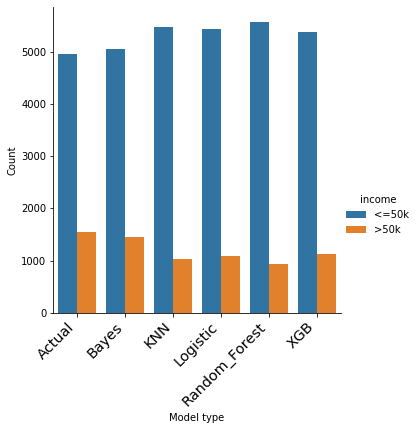

In [157]:
import seaborn as sns

plt.figure(figsize=(10,20))

chart = sns.catplot(
    x='Model_type', y='age',
    hue='income', kind='bar',
    data=results.groupby(['Model_type', 'income'])['age'].count().reset_index()
    )
chart.set_axis_labels("Model type", "Count")

plt.xticks(
    rotation = 45,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'x-large'
)

We see that all of our models under-estimate the number of high-income individuals compared to the original dataset. Given the skewed distribution of our predicting variable, it's unsurprising that our models tend to err towards guessing "low-income". Out of all our models, Naive Bayes best captures that original distribution. 

This visual is interesting because it compares the total number of classifications to what we have in our original dataset for each model. If someone prefers a more optimistic model, where they would rather mis-classify individuals as high-income rather than mis-classify as low-income, they would choose the Bayes model, whereas if the opposite tradeoff is desired, Random Forest might serve better. 

In [182]:
jobs_ct = pd.crosstab([results.jobtype, results.Model_type], results.income).reset_index()
jobs_ct['sum'] = jobs_ct["<=50k"] + jobs_ct[">50k"]
jobs_ct['pct'] = jobs_ct[">50k"] / jobs_ct["sum"]

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

<Figure size 720x1440 with 0 Axes>

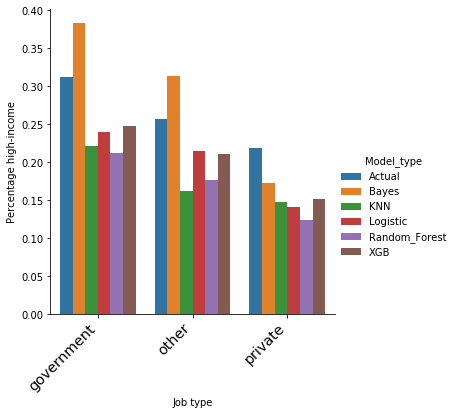

In [185]:
plt.figure(figsize=(10,20))

chart = sns.catplot(
    x='jobtype', y='pct',
    hue='Model_type', kind='bar',
    data=jobs_ct
    )
chart.set_axis_labels("Job type", "Percentage high-income")

plt.xticks(
    rotation = 45,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'x-large'
)

If we add in job type as a grouping variable, we see some more diverse trends. The Naive Bayes model actually over-predicts the percentage of high-income individuals in the "government" and "other" job descriptions. Overall, at each job level it is the most "optimistic" model, which agrees with our previously examined bar chart. 

This visual is interesting because there is now a breakdown of classification by job type. If an individual is using our analysis to decide whether to take a government job or not, he/she may be wary of using our Naive Bayes if he/she is pessimistic about their future earning potentials and wants to err on the safe side of income projections. 

We can also compare the ROC curves illustrated above in one plot, for each of our different models. 

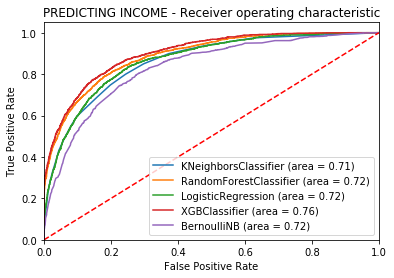

In [63]:
# https://github.com/naivelogic/Machine_Learning_Notebooks/blob/e0cf78b15c15f433d7d9d35dc7ad30cfe4d8cfda/Titanic%20Survival%20Prediction.ipynb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])

logit1_roc_auc = roc_auc_score(y_test, logit1.predict(X_test))
logit1_fpr, logit1_tpr, logit1_thresholds = roc_curve(y_test, logit1.predict_proba(X_test)[:,1])


xgb_best_roc_auc = roc_auc_score(y_test, xgb_best.predict(X_test))
xgb_best_fpr, xgb_best_tpr, xgb_best_thresholds = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])


nb_roc_auc = roc_auc_score(y_test, nb.predict(X_test))
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(knn_fpr, knn_tpr, label='KNeighborsClassifier (area = %0.2f)' % knn_roc_auc)
plt.plot(tree_fpr, tree_tpr, label='RandomForestClassifier (area = %0.2f)' % tree_roc_auc)

plt.plot(logit1_fpr, logit1_tpr, label='LogisticRegression (area = %0.2f)' % logit1_roc_auc)
plt.plot(xgb_best_fpr, xgb_best_tpr, label='XGBClassifier (area = %0.2f)' % xgb_best_roc_auc)
plt.plot(nb_fpr, nb_tpr, label='BernoulliNB (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PREDICTING INCOME - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Predicting_Income_ALL_ROC')

This plot is interesting because it directly compares the ROC curves from each model to one another. We see that the curve for our XGB classifier is the highest, corresponding to what we saw earlier from exploring the AUC. This means that relative to other models, the XGB classifier exhibits the strongest precision scores for classifying high-income individuals. 

### Classification Task 2. Predicting Sex

Our secondary model is concerned with determining an individual's gender. Using the same metrics discussed in the previous section, our best models are:

- Female precision: XGB
- Female recall: Logistic regression
- Male precision: Logistic regression
- Male recall: XGB
- Accuracy: XGB
- AUC: Logistic regression

In [221]:
# Load the dataset
df = pd.read_csv("./data/lab2_df.csv")
# define variables for classificaiton training
variables_ = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'income', 'jobtype_government', 'jobtype_other', 'jobtype_private']
y=df['sex_Male']
X=df[variables_]
# test train scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [222]:
logistic_s = LogisticRegression(C = 10, solver = 'lbfgs')
logistic_s.fit(X_train, y_train)
logistic_s_out = logistic_s.predict(X_test)

knn_s = KNeighborsClassifier(n_neighbors=21, metric='manhattan', weights='uniform')
knn_s.fit(X_train, y_train)
knn_s_out = knn_s.predict(X_test)

rf_s = RandomForestClassifier(max_depth=10, n_estimators=150)
rf_s.fit(X_train, y_train)
rf_s_out = rf_s.predict(X_test)

xgb_s = xgb_sClassifier(learning_rate=0.2, max_depth=5, objective='binary:logistic')
xgb_s.fit(X_train, y_train)
xgb_s_out = xgb_s.predict(X_test)

bayes_s = BernoulliNB(alpha=1.0, fit_prior=True)
bayes_s.fit(X_train, y_train)
bayes_s_out = bayes_s.predict(X_test)

In [230]:
combined = pd.DataFrame({"Actual" : y_test, "Logistic" : logistic_s_out, "KNN" : knn_s_out, 
                         "Random_Forest" : rf_s_out, "XGB": xgb_s_out, "Bayes": bayes_s_out})

In [233]:
variables_ = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'income', 'jobtype_government', 'jobtype_other', 'jobtype_private']
results = pd.concat([df.iloc[combined.index,], combined], axis=1)
results.drop(columns = ['Unnamed: 0'], inplace=True)

# Reshape predictions
results = pd.melt(results, id_vars=variables_, value_vars=["Actual", "Logistic", "KNN", "Random_Forest", "XGB", "Bayes"], 
                  var_name = "Model_type", value_name="sex_Male")

# Reformat results
results['jobtype'] = ["private" if i==1 else "other" for i in results.jobtype_private]
results.loc[(results.jobtype=="other") & results.jobtype_government==1, 'jobtype'] = "government"
results.drop(columns=["jobtype_government", "jobtype_other", "jobtype_private"], inplace=True)

results["income"] = [">50k" if int(i) == 1 else "<=50k" for i in results.income]
results['sex'] = ["Male" if int(i) ==1 else "Female" for i in results.sex_Male]

To tie this analysis in with our earlier one, let's visualize our predictions through grouping by income level. 

(array([0, 1]), <a list of 2 Text xticklabel objects>)

<Figure size 720x1440 with 0 Axes>

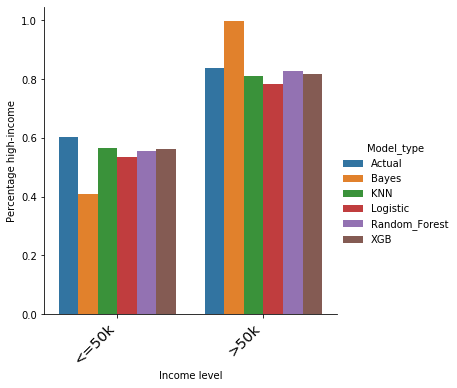

In [234]:
income_sex = pd.crosstab([results.income, results.Model_type], results.sex).reset_index()
income_sex['sum'] = income_sex["Male"] + income_sex["Female"]
income_sex['pct'] = income_sex["Male"] / income_sex["sum"]

plt.figure(figsize=(10,20))

chart = sns.catplot(
    x='income', y='pct',
    hue='Model_type', kind='bar',
    data=income_sex
    )
chart.set_axis_labels("Income level", "Percentage high-income")

plt.xticks(
    rotation = 45,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'x-large'
)

This chart is interesting because we see that naive bayes does not do a great job in classifying the right percentage of men/women in either income bucket. It overclassifies women in the low-income bracket, and overclassifies men in the high-income bracket. The other models tend to under-estimates men in both income brackets, compared to the actual values. 

In [236]:
combined.Actual.sum() / combined.shape[0]

0.6580684784277598

We have more males than females in the testing set, so this is another imbalanced sample problem. Interestingly, we are underestimating the larger sample here, when in our income model we over-estimated the larger sample (low-income). 

In [237]:
combined.sum() / combined.shape[0]

Actual           0.658068
Logistic         0.592968
KNN              0.622447
Random_Forest    0.619991
XGB              0.623062
Bayes            0.549363
dtype: float64

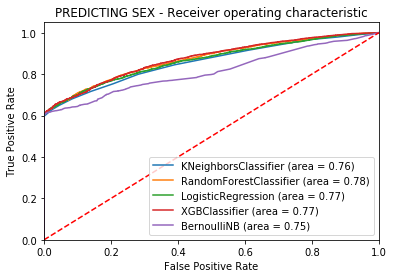

In [27]:
# https://github.com/naivelogic/Machine_Learning_Notebooks/blob/e0cf78b15c15f433d7d9d35dc7ad30cfe4d8cfda/Titanic%20Survival%20Prediction.ipynb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])

logit1_roc_auc = roc_auc_score(y_test, logit10.predict(X_test))
logit1_fpr, logit1_tpr, logit1_thresholds = roc_curve(y_test, logit10.predict_proba(X_test)[:,1])


xgb_best_roc_auc = roc_auc_score(y_test, xgb_best.predict(X_test))
xgb_best_fpr, xgb_best_tpr, xgb_best_thresholds = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])


nb_roc_auc = roc_auc_score(y_test, nb.predict(X_test))
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(knn_fpr, knn_tpr, label='KNeighborsClassifier (area = %0.2f)' % knn_roc_auc)
plt.plot(tree_fpr, tree_tpr, label='RandomForestClassifier (area = %0.2f)' % tree_roc_auc)

plt.plot(logit1_fpr, logit1_tpr, label='LogisticRegression (area = %0.2f)' % logit1_roc_auc)
plt.plot(xgb_best_fpr, xgb_best_tpr, label='XGBClassifier (area = %0.2f)' % xgb_best_roc_auc)
plt.plot(nb_fpr, nb_tpr, label='BernoulliNB (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PREDICTING SEX - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Predicting_SEX_ALL_ROC')

This plot is interesting because, like in the income analysis, it compares the receiver operator characteristic curve between all 5 models. We see that the Bayesian model stands out negatively compared to our other classifiers, showing a higher false positive rate at all classification threshholds. Additionally, our sex models are not anchored at 0,0 - indicating that even at extreme classification threshholds, we do not falsely classify females as males. The y-intercept for our ROC curves is close to the existing percentage of males in our dataset.

## Modeling and Evaluation 5

Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

In general each model have a specific advantage such as:
1. Logistic regression :can be Outputs have a nice probabilistic interpretation, and the algorithm can be regularized to avoid overfitting. Logistic models can be updated easily with new data using stochastic gradient descent
2. Knn:it's easy to implemnt and training is faster
3. Random forest: no requirement for domain knowledge and it can easily process data with high dimension
4. XGBClassifier:implement parallel process and high flexible

### Classification Task 1 : Income prediction

In [2]:
### Using Income classification
# statiscal  comparaison between logistic/radomforest/knn/XGBClassifier
lr_model_auc = [0.86365938,0.89234763,0.84004673, 0.8753299, 0.86297003, 0.89124357,
 0.84630593, 0.86006764, 0.86049688, 0.87225546]
rfc_model_auc = [0.87061725, 0.9188291,  0.85198936, 0.88262693, 0.8784852,  0.90943061,
 0.86634365, 0.8808988,  0.87514958, 0.88338319]
knn_model_auc = [0.83427014, 0.88464334, 0.80484845, 0.85937051, 0.81934464, 0.87231833,
 0.82014828, 0.84786681, 0.83368887, 0.85414932]
gbx_model_auc = [0.88187188, 0.92467709, 0.8664633, 0.88998929, 0.88330633, 0.91045624,
 0.88343522, 0.89081686, 0.88093132, 0.88407258]

In [7]:
numpy_data = np.array([lr_model_auc,rfc_model_auc, knn_model_auc, gbx_model_auc]).transpose()
df_auc = pd.DataFrame(data=numpy_data, columns=["lr_model_auc", "rfc_model_auc", "knn_model_auc", "gbx_model_auc"])
df_auc.head(10)

,lr_model_auc,rfc_model_auc,knn_model_auc,gbx_model_auc
0,0.863659,0.870617,0.834270,0.881872
1,0.892348,0.918829,0.884643,0.924677
2,0.840047,0.851989,0.804848,0.866463
3,0.875330,0.882627,0.859371,0.889989
4,0.862970,0.878485,0.819345,0.883306
5,0.891244,0.909431,0.872318,0.910456
6,0.846306,0.866344,0.820148,0.883435
7,0.860068,0.880899,0.847867,0.890817
8,0.860497,0.875150,0.833689,0.880931
9,0.872255,0.883383,0.854149,0.884073


To compare the AUC's for each of our 4 models, we can first do an analysis of variance to determine if there's any mean difference between each model. 

In order to apply anova we need to assume that the following assunpting are met:

1. The normality criterion: each group compared should come from a population following the normal distribution.
2. The variance criterion (or 'homogeneity of variances'): samples should come from populations with the same variance.
3. Independent samples: performance (the dependent variable) in each sample should not be affected by the conditions in other samples.

Given the nature of our "dataset" in this case, which is the AUC for each of 4 different models fit on 10 random folds of our training dataset, we can assume that the assumptions are met. Equal normality and variance can be assumed from the central limit theorem given the size of our training set and the random nature of our cross validation. Independence can also be assumed since each instance represents a different training and testing set entirely. 


In [19]:
import scipy.stats as stats
#Apply one way ANOVA by calling the f_oneway() method
F, p = stats.f_oneway(df_auc["lr_model_auc"], df_auc["rfc_model_auc"], df_auc["knn_model_auc"], df_auc["gbx_model_auc"])
print('F statistic = {:5.3f} and probability p = {:5.8f}'.format(F, p)) 

F statistic = 1.475 and probability p = 0.23753616


#### Intepretation

As p < 0.05 we  reject the null hypothesis that at least one model's mean AUC is different from the others at a statistically significant level. However, this result does not identify the sample pair (or pairs) which cause this significance.
We can identify the the group by implementing ordinary Tukey's range test, see below

__NOTE: SEE APPENDIX FOR SAS CODE__



__INCOME Tukey Multiple Comparision Test__


![](./multiple_comparisions/income_multicomp_tukeytest.png)

The Tukey Multiple Comparison performs the pairwise group mean differences tests with an adjusted p-value to correct for the multiple comparisons problem, where the probability of seeing a signficant mean difference increases as the number of comparisons increases. For example, we see that the group mean for XGB is greater than the group mean for any other model, as we expected from our ROC plots above. However, that mean difference is only significant when comparing to the K Neighbors and Naive Bayes models. The 95% confidence interval for the mean AUC difference between the XGB and logistic regression models spans from -.003 to 0.5, meaning the null hypothesis value of 0 is included. Thus we fail to reject the null hypothesis that the AUC for the XGB model is equal to the AUC for the logit model or the random forest model, but reject the null hypothesis that the XGB AUC is equal to the KNN and Naive Bayes models.  

___Group means plot for income___

![](./multiple_comparisions/income_multicomp_tukeytest_groupmeans.png)

The bars are sorted by mean AUC across each of the 10 folds, and shows the significance or insignificance of the various group means. As confirmed above, the XGB/Random Forest/Logit mean AUCs are not differentiable statistically, but are differentiable from KNN/Naive Bayes. 

#### Classification Task 2: Predicting Sex

We'll do the same multiple comparison test for our sex classification task. 


__SEX Tukey Multiple Comparision Test__


![](./multiple_comparisions/sex_multicomp_tukeytest.png)

___sex_multicomp_tukeytest_group means___

![](./multiple_comparisions/sex_multicomp_tukeytest_groupmeans.png)

This time, we see that Naive Bayes performs significantly worse than the other 4 models. However, neither of the other 4 are differentiable on the basis of mean AUC. 

## Modeling and Evaluation 6

Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

#### Feature Importance - KNN

Feature importance is not an attribute of KNN. In a nearest neighbors model, only the k "closest" points chosen by our selected distance metric determine the classification of the outcome variable. Of course, absolute magnitude can be a large factor. For example, if age and capital gains are to be weighted equally in our initial dataset, age will almost always be closer using any distance metric, as the scale for age ranges from 0-98 whereas capital gains can range from 0 - 10,000. However, given that we scaled all of our features using the StandardScalar to be mean 0 and unit standard deviation, absolute magnitude should not play a factor. 

#### [Income] Feature Importance - Logistic Regression

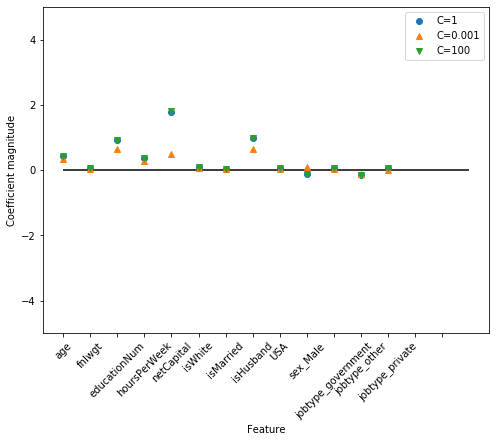

In [58]:
plt.figure(figsize=(8,6))
plt.plot(logit1.coef_.T, 'o', label="C=1")
plt.plot(logit001.coef_.T, '^', label="C=0.001")
plt.plot(logit100.coef_.T, 'v', label="C=100")
plt.xticks(range(df.shape[1]), variables_, rotation=45)
plt.hlines(0, 0, df.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
#plt.savefig('log_coef')

#print("Feature importances:\n{}".format(logit.feature_importances_))
#AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

__Analysis on Feature Importance - Logistic__
The plot above shows in the case for about all experiments with the Inverse Regularization Parameter that features `educaitonNum`, `netCapital` and `isHusband` appear to be solid features that are important to the model outcome.

In [54]:
def plot_feature_importances_(model):
    plt.figure(figsize=(8,6))
    n_features = 13
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), variables_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

#### [Income] Feature Importance - RandomForestClassifier

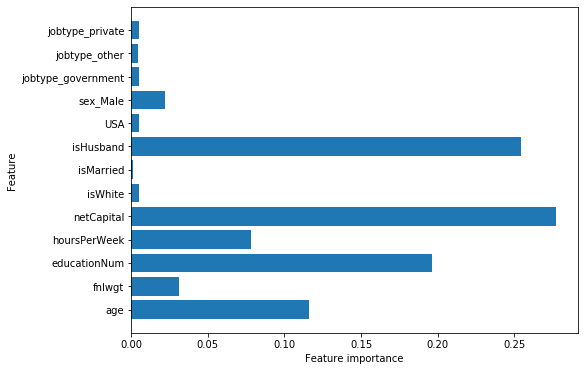

In [30]:
plot_feature_importances_(tree)
#plt.savefig('[income] feature_importance_RandomForestClassifier')

Reviewing the Feature Importance in the `RandomForestClassifier` we see similar important features that is also shared with te Logistic Regression model, where the following features proved to have the highest importance for predicting income when using the `RandomForestClassifier`:
* `isHusband`
* `netcapital`
* `hoursPerWeek`
* `educationNum`
* `age`

#### [Income] Feature Importance - XGBoost Classifier

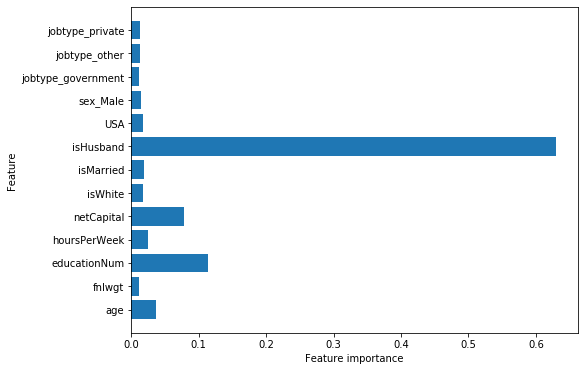

In [31]:
plot_feature_importances_(xgb_best)

Reviewing the Feature Importance in the `XGBoost Classifier` we see similar important features that is also shared with the other models experiments, most significatlly, XGBoost indicates that `isHusband` is by far this most important feature for predicting income. `educationNum` and `netCapital` come in a distance 2nd and 3rd important features. 

#### [Income] Feature Importance - Naive Bayes

In [11]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB
nb= BernoulliNB(alpha=0.1)
nb.fit(X_train, y_train)


neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

#print( neg_class_prob_sorted[:10])
#print( pos_class_prob_sorted[:10])

print("Naive Bayes")
print("The most important features are 6,4,11,10")
variables = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'sex_Male', 'jobtype_government', 'jobtype_other', 'jobtype_private']
print("These features are %s, %s,%s, %s" %(variables[6], variables[4], variables[11],variables[10]))

Naive Bayes
The most important features are 6,4,11,10
These features are isMarried, netCapital,jobtype_other, jobtype_government


---
#### Feature Importance SEX

#### Feature Importance [SEX] - Logistic Regression

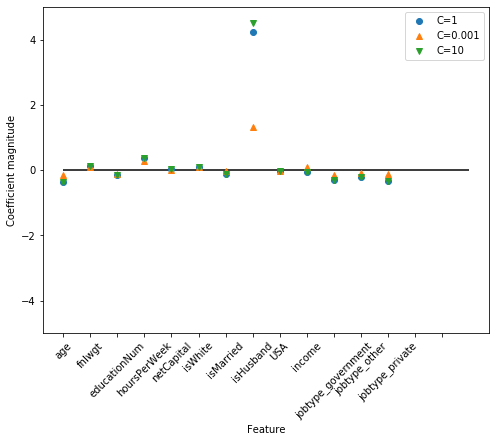

In [24]:
plt.figure(figsize=(8,6))
plt.plot(logit1.coef_.T, 'o', label="C=1")
plt.plot(logit001.coef_.T, '^', label="C=0.001")
plt.plot(logit10.coef_.T, 'v', label="C=10")
plt.xticks(range(df.shape[1]), variables_, rotation=45)
plt.hlines(0, 0, df.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
#plt.savefig('log_coef')

#print("Feature importances:\n{}".format(logit.feature_importances_))
#AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

__Analysis on Feature Importance - Logistic__
The plot above shows a quite similar output when compared to the _Predicting Income XGBoost_ results where across  all experiments with the Inverse Regularization Parameter, `isHusband` is a significant indicator for predicting sex. Distance 2nd important freature is `educationNum` for predicting SEX.

#### [Predicting SEX] Feature Importance - RandomForestClassifier

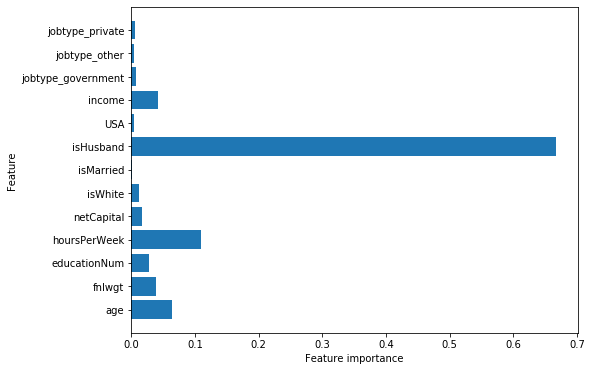

In [20]:
plot_feature_importances_(tree)
#plt.savefig('[income] feature_importance_RandomForestClassifier')

Reviewing the Feature Importance in the `RandomForestClassifier` we see similar important features that is also shared with te Logistic Regression model, where the following features proved to have the highest importance for predicting SEX when using the `RandomForestClassifier`:
* `isHusband`
* `hoursPerWeek`
* `educationNum`
* `age`
* `income`

#### [Predicting SEX] Feature Importance - XGBoost Classifier

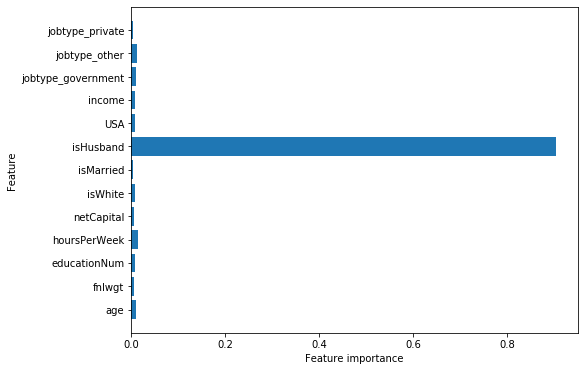

In [21]:
plot_feature_importances_(xgb_best)

Reviewing the Feature Importance in the `XGBoost Classifier` we see similar important features that is also shared with the other models experiments, most significatlly, XGBoost indicates that `isHusband` is by far this most important feature for predicting sex. 



#### [Predicting SEX] Feature Importance - Naive Bayes

In [13]:
# code adapted from https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
import numpy as np
nb = BernoulliNB(alpha=0.1)
nb.fit(X_train, y_train)

neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
variables_ = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'income', 'jobtype_government', 'jobtype_other', 'jobtype_private']
#print( neg_class_prob_sorted[:10])
#print( pos_class_prob_sorted[:10])
print("Naive Bayes")
print("The top four variables are %s, %s, %s, and %s." %(variables_[6] ,variables_[7], variables_[11], variables_[4]))

Naive Bayes
The top four variables are isMarried, isHusband, jobtype_other, and netCapital.


## Deployment

>How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

##### Deployment Strategy and Architecture
The Census Bureau is our target audience to deploy our process for data colleciton, analsyis, feature prediction as shown above to provide accurate results for the goverment to take aciton on. Our deployment strategy is to use a cloud hosting solution on Azure using a similar architecture for the Bureau teams to use at any remote location with a focus on security, privacy, data availablity and analytics offerings that Azure inherently provides:

![](https://www.znetlive.com/blog/wp-content/uploads/2017/08/machine-learning1.png)

This offering will be a cloud hosted where the backend SQL and Webservices hosting various dashboards and reporting tools tha can meet the scale and timliness the Census Buraru offers. Since the core Census data used in this notebook specifically only involes the decate frequency for predicting sex and income, the data does only needs to be updated during the survey collection and anaysis period, so one-two year, depending on contractual agreements with the Bureau.

Essentially, using the WebServices offered, currently, the deployment for the above models can been deployed as such. Hosted models are processed with data stored in Azure SQL/Tables and all model is performed in AzureML. Final models for predicting Sex and Income are registered in AzureML with an API response string for WebServices to be called and new predictins to be performed. 


The data as well as the other datasets to combined for the Census Bureau and other agencies such as IRS described below, can be stored in Azure tables, Hadoop and SQL for various processing needs. The data used here for the above 2 classification problem can easily be stored in Azure Tables and SQL and can be stored in those same resources for the backend Webservier that is made accessible to the Census Bureau for thier application and analyst to access. 


##### Deployment Solutions, Usability, and Future Feature Enhancements
As we move into the 2020Census, our solution is best positioned to be pilotied with the Census Bureau to address seed to analsys, trend analysis and evaluation of new redsigns to determine whether certain new objective were met. Such goal, involves a recent redesign sa described in the expert from a census article below: 

![](https://image.slidesharecdn.com/censuspresentation-161111145704/95/census-2020-the-count-startsnow-36-638.jpg?cb=1478876267)

The Census Bureau has made changes to the way data is collected. With our solution and future implementation such as adding addiitonal datasets to follow-up feedback to obtain how valuable the questions and analysis are valuable to customers (e.g., citizens, organizations, schools, federal departments).

Moreover, provideing feedback system that we can provide sentiment anlaysis based off the results, we can provide those resposible metrics on which region, demographic has been identified with positive and negative input from the lates Census experiment. 

Additionally, another census article that was identified where researching more informaiton on the various data inputs and supporting processes to consider for the Census Bureau, we found these proposed draft changes to be of interest for future feature enhancements that can be offered to the Census Bureau: 

![](https://www.bing.com/th?id=OIP.TSSNbAyoJu1_UEtjaNUHcgHaEU&pid=Api&rs=1)


If additional datasets where incorporated and made available for our analysis, the deployed solution should be able to provide trend results to support additional reasources (e.g., addiditonal teaches allocated to increased population community areas). Additionally, the use of historical detail information that the bureau maintains, we can assist the internal employees to increase their productivity and evaluations. One enhanced feature that could be offered with additioal information on the population and perhaps combining datasets with the IRS is to provide employees that are responsible for various regious of the US to have dashboards that indicate the likelihood/or directly identifies if there are significant non-reported census in regions for follow-up activities to occur in those communities. 

__This would ensure that all communities provide unbias results and have an equal opportunity to be represented for goverment provided resources (e.g., schools, teachers, public resources, infrastructure fixes) based off an accurate representation of the communities census__


## Exceptional Work

> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

# Neural Network

### MLPClassifier
A multilayer perceptron (MLP) is a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs.

> class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)


Activation Functions
* BinaryStep
* Gaussian
* HyperbolicTangent
* Parametric Rectified Linear Unit
* Sigmoid (default)
* Thresholded Rectified Linear Unit


_Resources_
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
* https://php-ml.readthedocs.io/en/latest/machine-learning/neural-network/multilayer-perceptron-classifier/

In [6]:
# Data Processing
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Ignore the warnings if any
import warnings  
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the dataset
df = pd.read_csv("../data/lab2_df.csv")

# define variables for classificaiton training
variables_ = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'sex_Male', 'jobtype_government', 'jobtype_other', 'jobtype_private']
y=df['income']
X=df[variables_]

# test train scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# prepare cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [7]:
from sklearn.neural_network import MLPClassifier

parms = [1, 0.1, 0.001, 3 ]
for param in parms:
    net = MLPClassifier(random_state=0, max_iter=1000, alpha=param)
    net.fit(X_train, y_train)
    print("")
    print("---- Accuracy Results for alpha={} ----".format(param))
    print("net alpha={} Train accuracy: {:.3f}".format(param,cross_val_score(net, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
    print("net alpha={} Test accuracy: {:.3f}".format(param,cross_val_score(net,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))
    


---- Accuracy Results for alpha=1 ----
net alpha=1 Train accuracy: 0.880
net alpha=1 Test accuracy: 0.876

---- Accuracy Results for alpha=0.1 ----
net alpha=0.1 Train accuracy: 0.891
net alpha=0.1 Test accuracy: 0.877

---- Accuracy Results for alpha=0.001 ----
net alpha=0.001 Train accuracy: 0.888
net alpha=0.001 Test accuracy: 0.869

---- Accuracy Results for alpha=3 ----
net alpha=3 Train accuracy: 0.870
net alpha=3 Test accuracy: 0.868


We can see as alpha increses test accuracy decreases with train accuracy decreasinging. 

#### Feature Importance - PREDICTING INCOME

__Heat map to visualuze the weights of the features__

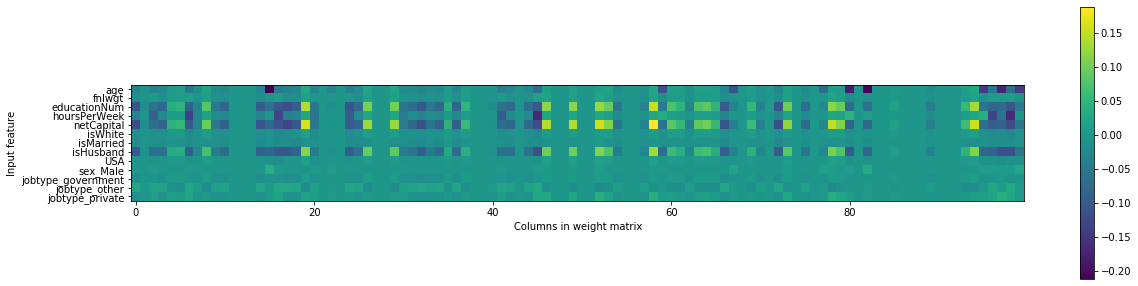

In [11]:
plt.figure(figsize=(20, 5))
plt.imshow(net.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(len(variables_)), variables_)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

Hard to see initially but we can see form the weight matrix which features hace the most weights for the layers. 

#### Neural Net Hyperparameter tuning- Predicing Income

In [ ]:
param_grid = [{'early_stopping': [True],
               'alpha': [0.0001, 0.001, 0.01],
               'hidden_layer_sizes': [32, 64, (64, 64), 128, 256]
              }]
net = GridSearchCV(MLPClassifier(), param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)

model_eval([("NeuralNet", net)])

NeuralNet Start training...
----NeuralNet Classifier Hyperparameter tuning Results ----
Best NeuralNet Score: 0.8897890549610346 
Best NeuralNet Parameters: {'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 128} 


In [21]:
from sklearn.neural_network import MLPClassifier
net = MLPClassifier(alpha=0.001, early_stopping= True, hidden_layer_sizes= 128)
net.fit(X_train, y_train)
model_prediction = net.predict(X_test)
print(classification_report(y_test, model_prediction))
print("net Train accuracy: {:.3f}".format(cross_val_score(net, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("net Test accuracy: {:.3f}".format(cross_val_score(net,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))
    

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4966
           1       0.75      0.51      0.61      1547

    accuracy                           0.84      6513
   macro avg       0.81      0.73      0.76      6513
weighted avg       0.84      0.84      0.83      6513

net Train accuracy: 0.889
net Test accuracy: 0.871


net net testing accuray did not improve. 

![](./dev/Predicting_Income_ALL_ROC_AND_NET.png)

Above is the ROC curve for predicing income. The MLPClassifier provide to be on the higher end of the accuracy than the other models desscribed in this notebook. Just below `XGBoost Classifier`

----
# Appendix

To see the full outputs from the GridSearchCV that was referenced in the above sections for hyperparameter tuning see sections below:
* Predicting INCOME Grid Search Output
* Predicting SEX Grid Search Output
* Functions to initialize for ROC and Eval outputs

---
### Predicting INCOME Grid Search Output

LogisticRegression Start training...
----LogisticRegression Classifier Hyperparameter tuning Results ----
Best LogisticRegression Score: 0.8686701592631874 
Best LogisticRegression Parameters: {'C': 1, 'solver': 'sag'} 


Elapsed Time: 41.520306
---- model selection ----

LogisticRegression Classifier test CV results: [0.86365938 0.89234763 0.84004673 0.8753299  0.86297003 0.89124357
 0.84630593 0.86006764 0.86049688 0.87225546]
LogisticRegression Classifier test MEAN CV results: 0.86647231470502


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4966
           1       0.53      0.80      0.64      1547

    accuracy                           0.79      6513
   macro avg       0.73      0.79      0.74      6513
weighted avg       0.83      0.79      0.80      6513



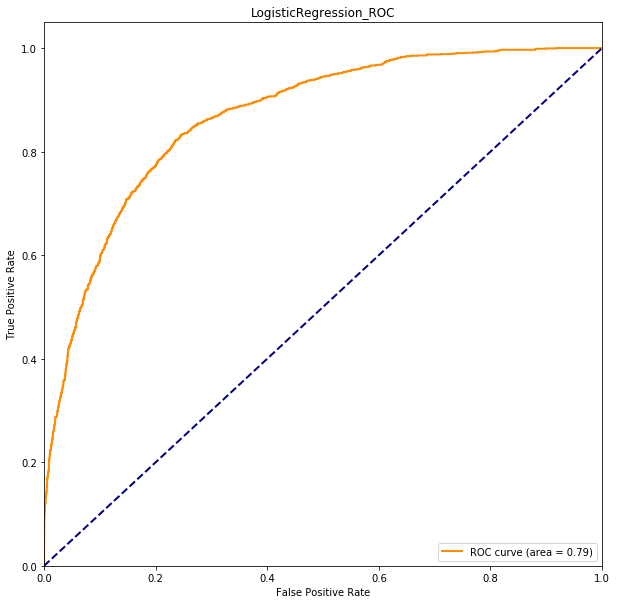

KNNClassifier Start training...
----KNNClassifier Classifier Hyperparameter tuning Results ----
Best KNNClassifier Score: 0.8637542443095839 
Best KNNClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'} 


Elapsed Time: 318.177782
---- model selection ----

KNNClassifier Classifier test CV results: [0.83427014 0.88464334 0.80484845 0.85937051 0.81934464 0.87231833
 0.82014828 0.84786681 0.83368887 0.85414932]
KNNClassifier Classifier test MEAN CV results: 0.8430648677801365


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      4966
           1       0.72      0.48      0.58      1547

    accuracy                           0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513



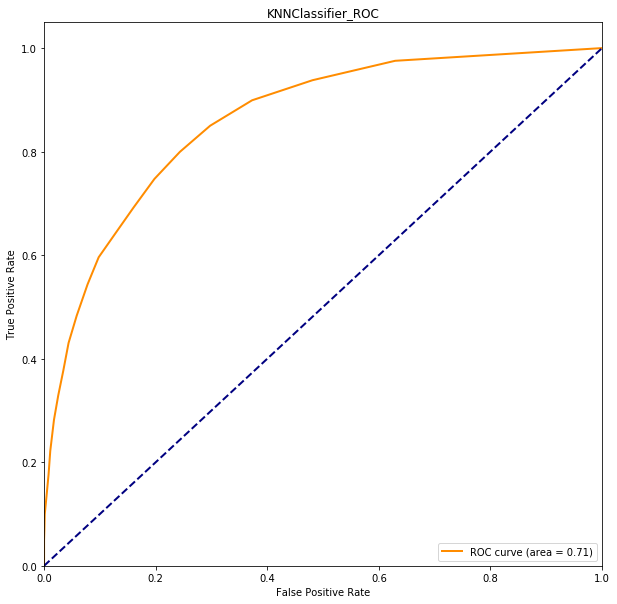

RandomForestClassifer Start training...
----RandomForestClassifer Classifier Hyperparameter tuning Results ----
Best RandomForestClassifer Score: 0.8950631829144058 
Best RandomForestClassifer Parameters: {'max_depth': 10, 'n_estimators': 100} 


Elapsed Time: 337.653548
---- model selection ----

RandomForestClassifer Classifier test CV results: [0.87061725 0.9188291  0.85198936 0.88262693 0.8784852  0.90943061
 0.86634365 0.8808988  0.87514958 0.88338319]
RandomForestClassifer Classifier test MEAN CV results: 0.8817753682112677


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4966
           1       0.80      0.49      0.61      1547

    accuracy                           0.85      6513
   macro avg       0.83      0.73      0.76      6513
weighted avg       0.84      0.85      0.84      6513



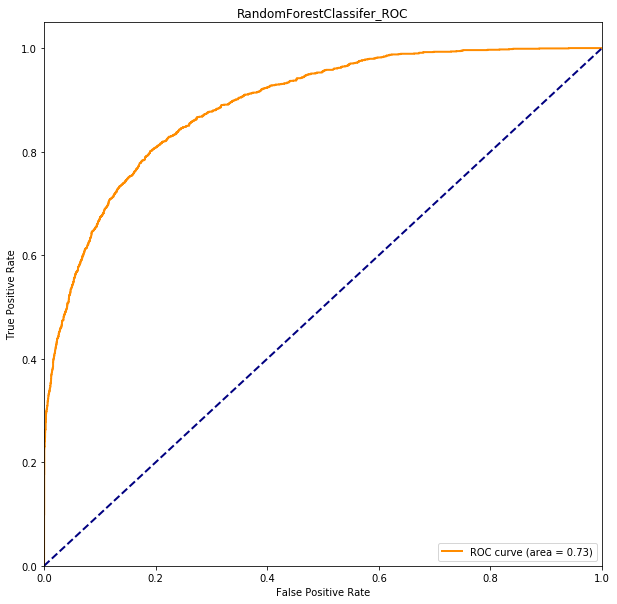

XGBClassifier Start training...
----XGBClassifier Classifier Hyperparameter tuning Results ----
Best XGBClassifier Score: 0.90808818242688 
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'} 


Elapsed Time: 1339.558055
---- model selection ----

XGBClassifier Classifier test CV results: [0.88187188 0.92467709 0.8664633  0.88998929 0.88330633 0.91045624
 0.88343522 0.89081686 0.88093132 0.88407258]
XGBClassifier Classifier test MEAN CV results: 0.8896020112322244


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4966
           1       0.77      0.56      0.65      1547

    accuracy                           0.86      6513
   macro avg       0.82      0.76      0.78      6513
weighted avg       0.85      0.86      0.85      6513



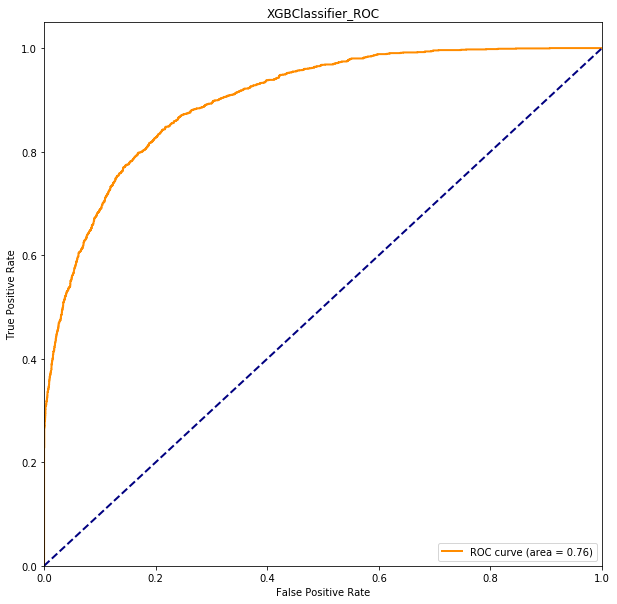

In [7]:
models=[('LogisticRegression',lr_model),
        ('KNNClassifier',knn_model),
        ('RandomForestClassifer',rfc_model),
        ('XGBClassifier',gbx_model)]

model_eval(models)

---

### Predicting SEX Grid Search Output

LogisticRegression Start training...
----LogisticRegression Classifier Hyperparameter tuning Results ----
Best LogisticRegression Score: 0.8633324043194153 
Best LogisticRegression Parameters: {'C': 10, 'solver': 'lbfgs'} 


Elapsed Time: 240.602797
---- model selection ----

LogisticRegression Classifier test CV results: [0.87880878 0.83800056 0.883868   0.86196094 0.85527639 0.86191903
 0.88787142 0.85948886 0.83444633 0.88207438]
LogisticRegression Classifier test MEAN CV results: 0.8643714711492677


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.58      0.98      0.73      2227
           1       0.98      0.63      0.77      4286

    accuracy                           0.75      6513
   macro avg       0.78      0.81      0.75      6513
weighted avg       0.85      0.75      0.76      6513



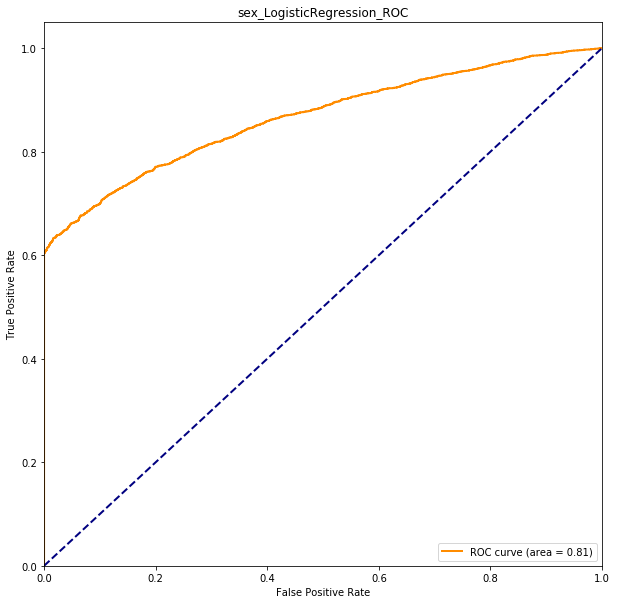

KNNClassifier Start training...
----KNNClassifier Classifier Hyperparameter tuning Results ----
Best KNNClassifier Score: 0.8585870322129203 
Best KNNClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'} 


Elapsed Time: 325.311473
---- model selection ----

KNNClassifier Classifier test CV results: [0.86635935 0.82328285 0.87258929 0.84439043 0.85312854 0.85923159
 0.85346381 0.85377685 0.82512233 0.86859237]
KNNClassifier Classifier test MEAN CV results: 0.8519937404513701


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      2227
           1       0.85      0.80      0.82      4286

    accuracy                           0.77      6513
   macro avg       0.75      0.76      0.75      6513
weighted avg       0.78      0.77      0.77      6513



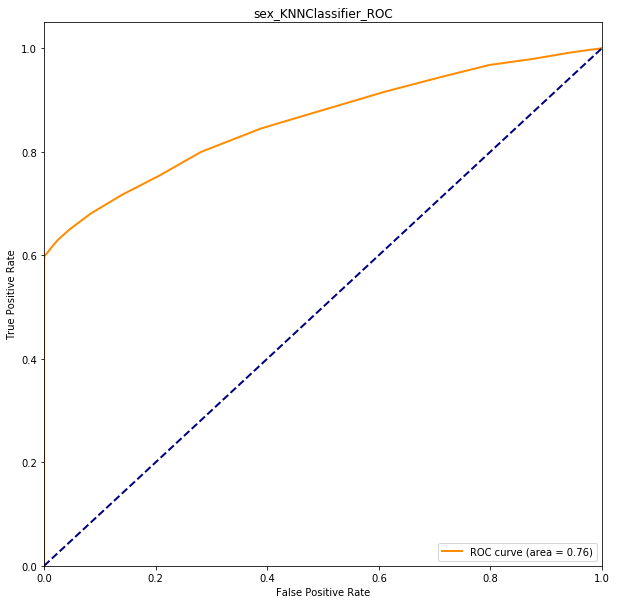

RandomForestClassifer Start training...
----RandomForestClassifer Classifier Hyperparameter tuning Results ----
Best RandomForestClassifer Score: 0.8706631138553972 
Best RandomForestClassifer Parameters: {'max_depth': 10, 'n_estimators': 150} 


Elapsed Time: 311.324724
---- model selection ----

RandomForestClassifer Classifier test CV results: [0.87722517 0.83509465 0.87715722 0.85164075 0.86443359 0.88400528
 0.8741461  0.87065562 0.84189084 0.88610639]
RandomForestClassifer Classifier test MEAN CV results: 0.866235561278728


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      2227
           1       0.86      0.80      0.83      4286

    accuracy                           0.78      6513
   macro avg       0.76      0.77      0.77      6513
weighted avg       0.79      0.78      0.79      6513



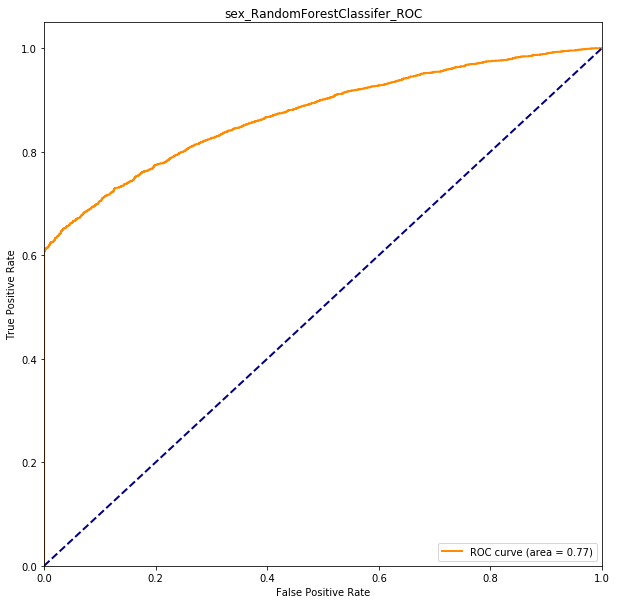

XGBClassifier Start training...
----XGBClassifier Classifier Hyperparameter tuning Results ----
Best XGBClassifier Score: 0.8737781024690019 
Best XGBClassifier Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'objective': 'binary:logistic'} 


Elapsed Time: 1114.636997
---- model selection ----

XGBClassifier Classifier test CV results: [0.88051261 0.83787513 0.87209801 0.84336889 0.86899648 0.87330791
 0.88682893 0.85821311 0.8517556  0.88441588]
XGBClassifier Classifier test MEAN CV results: 0.8657372542064088


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      2227
           1       0.86      0.81      0.83      4286

    accuracy                           0.79      6513
   macro avg       0.76      0.77      0.77      6513
weighted avg       0.79      0.79      0.79      6513



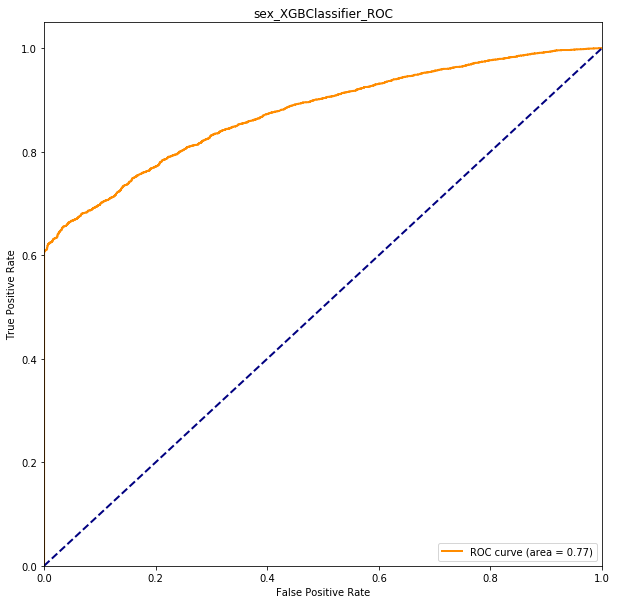

In [7]:
models=[('LogisticRegression',lr_model),
        ('KNNClassifier',knn_model),
        ('RandomForestClassifer',rfc_model),
        ('XGBClassifier',gbx_model)]

model_eval(models)

---

#### Functions to initialize for ROC and Eval outputs

In [46]:
from sklearn.metrics import accuracy_score,roc_curve,auc,precision_score,recall_score,f1_score,roc_auc_score

def evaluate(pre,pre_pro,y):
    acc=accuracy_score(y,pre)
    model_auc=roc_auc_score(y,pre)
    model_pre=precision_score(y,pre)
    model_recall=recall_score(y,pre)
    model_f1=f1_score(y,pre)
    fpr, tpr, thresholds =roc_curve(y,pre_pro[:,1])
    return acc,model_auc,model_pre,model_recall,model_f1,fpr,tpr


def model_eval(models):
    for name,model in models:
        print(name,'Start training...')
        model.fit(X_train,y_train)

        print("----{} Classifier Hyperparameter tuning Results ----".format(name))
        print("Best {} Score: {} ".format(name, model.best_score_))
        print("Best {} Parameters: {} ".format(name,model.best_params_))

        preds=model.predict(X_test)
        pro=model.predict_proba(X_test)
        acc,model_auc,model_pre,model_recall,model_f1,fpr,tpr=evaluate(preds,pro,y_test)

        start = time.time()
        model_results = cross_val_score(model, X_test, y_test,scoring='roc_auc',cv=kfold)
        end = time.time() - start
        print("")
        print("")
        print("Elapsed Time: %f" % (end))
        print("---- model selection ----")
        print("")
        print("{} Classifier test CV results: {}".format(name,model_results ))
        print("{} Classifier test MEAN CV results: {}".format(name,model_results.mean()))

        model_prediction = model.predict(X_test)
        print("")
        print("")
        print("---- Classification Report ----")
        print(classification_report(y_test, model_prediction))

        model_plot(fpr,tpr,name)
        
import matplotlib.pyplot as plt
def model_plot(fpr,tpr,name):
    #plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % model_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}_ROC'.format(name))
    plt.legend(loc="lower right")
    plt.savefig('{}_ROC.png'.format(name))
    plt.show()

---
## APPENDIX - Tukey Multiple Comparision Procedures in SAS
This code was adapted from Unit 5 ANOVA from MSDS 6371 Stats Foundations

```sas
/* This example shows the analyses for the one-way ANOVA */
/* using the rice data example we looked at in class */

/* Entering the data and defining the variables: */


/* Entering the data and defining the variables: INCOME */
DATA rice; 
INPUT VARIETY $ YIELD;
CARDS;
 logit 0.86365938 
 logit 0.89234763 
 logit 0.84004673 
 logit 0.8753299  
 logit 0.86297003 
 logit 0.89124357
 logit 0.84630593 
 logit 0.86006764 
 logit 0.86049688 
 logit 0.87225546
 KNN 0.83427014 
 KNN 0.88464334 
 KNN 0.80484845 
 KNN 0.85937051 
 KNN 0.81934464 
 KNN 0.87231833
 KNN 0.82014828 
 KNN 0.84786681 
 KNN 0.83368887 
 KNN 0.85414932
 tree 0.87061725 
 tree 0.9188291  
 tree 0.85198936 
 tree 0.88262693 
 tree 0.8784852  
 tree 0.90943061
 tree 0.86634365 
 tree 0.8808988  
 tree 0.87514958 
 tree 0.88338319
 XGB 0.88187188 
 XGB 0.92467709 
 XGB 0.8664633  
 XGB 0.88998929 
 XGB 0.88330633 
 XGB 0.91045624
 XGB 0.88343522 
 XGB 0.89081686 
 XGB 0.88093132 
 XGB 0.88407258
 NB 0.83012267 
 NB 0.87000065 
 NB 0.79059518 
 NB 0.83430453 
 NB 0.82393713 
 NB 0.8642439
 NB 0.79622138 
 NB 0.83316857 
 NB 0.82683403 
 NB 0.85491025
;
run;


/* Entering the data and defining the variables: SEX 
DATA rice; 
INPUT VARIETY $ YIELD;
CARDS;
 logit 0.87880878 
 logit 0.83800056 
 logit 0.883868   
 logit 0.86196094 
 logit 0.85527639 
 logit 0.86191903
 logit 0.88787142 
 logit 0.85948886 
 logit 0.83444633 
 logit 0.88207438
 KNN 0.86635935 
 KNN 0.82328285 
 KNN 0.87258929 
 KNN 0.84439043 
 KNN 0.85312854 
 KNN 0.85923159
 KNN 0.85346381 
 KNN 0.85377685 
 KNN 0.82512233 
 KNN 0.86859237
 TREE 0.87722517 
 TREE 0.83509465 
 TREE 0.87715722 
 TREE 0.85164075 
 TREE 0.86443359 
 TREE 0.88400528
 TREE 0.8741461  
 TREE 0.87065562 
 TREE 0.84189084 
 TREE 0.88610639
 XGB 0.88051261 
 XGB 0.83787513 
 XGB 0.87209801 
 XGB 0.84336889 
 XGB 0.86899648 
 XGB 0.87330791
 XGB 0.88682893 
 XGB 0.85821311 
 XGB 0.8517556  
 XGB 0.88441588
 NB 0.82368528 
 NB 0.79899025 
 NB 0.83330197 
 NB 0.78964628 
 NB 0.83388165 
 NB 0.80347638
 NB 0.80324064 
 NB 0.8043638  
 NB 0.80539281 
 NB 0.82190407
;
run;
*/

/******************************************************************************/

/* PROC GLM will do a standard analysis of variance                         */
/* We specify that VARIETY is a (qualitative) factor with a CLASS statement */
/* The model statement specifies that YIELD is the response                 */
/* and VARIETY is the factor                                                */


PROC GLM data=rice;
CLASS VARIETY;
MODEL YIELD = VARIETY;
run;

/******************************************************************************/

/* The following code produces some residual plots */
/* The MEANS statement produces the output */
/* for Levene's test for unequal variances */

PROC GLM data=rice;
CLASS VARIETY;
MODEL YIELD = VARIETY;
MEANS VARIETY/HOVTEST=LEVENE (TYPE=ABS);
OUTPUT OUT=diagnost p=ybar r=resid;
run;
PROC SGPLOT data=diagnost;
 SCATTER y=resid x=ybar;
 REFLINE 0;
run;
PROC UNIVARIATE noprint ;
  QQPLOT resid / normal;
run;

/* Note that according to Levene's test (P-value = 0.4654) we would  */
/* FAIL TO REJECT the null hypothesis that all variances are equal.  */
/* So the equal-variance assumption seems reasonable for these data. */

/* Notice there is some evidence of nonnormality based on the Q-Q plot */


/******************************************************************************/

/*  Estimating and testing contrasts */

/* The following code estimates the contrasts in the example from class             */
/* The ESTIMATE statement defines the constrast.  Note we need the divisor=3 option */
/* The ESTIMATE statement also uses a t-test to test whether a contrast is zero     

PROC GLM DATA=rice;
CLASS VARIETY;
MODEL YIELD = VARIETY;
MEANS VARIETY;
ESTIMATE 'Var4vsOthers'  VARIETY  1 1 1 -3 / divisor=3;
ESTIMATE '1vs2'	 VARIETY  1 -1 0 0;
RUN;

******************************************************************************/

/* Post Hoc Multiple Comparisons in SAS */

/* Adding options to a MEANS statement is the easiest way to implement a */
/* multiple comparisons procedure in SAS.                                */

PROC GLM DATA=rice;
CLASS VARIETY;
MODEL YIELD = VARIETY;
MEANS VARIETY / ALPHA=0.05 LSD TUKEY;
MEANS VARIETY / ALPHA=0.05 LSD TUKEY CLDIFF; /* same as above but output given in different style */
run;

/* ALPHA=0.05 is actually the default significance level.  We could choose */
/* another significance level if desired.                                  */

/* Notice the results for the Fisher LSD and Tukey procedures.  According to   */
/* Fisher, the mean for variety 4 is significantly different from the means of */
/* each other variety.  Tukey gives similar results, but Tukey's method does   */
/* NOT find a significant difference between varieties 1 and 4.                */
/* Recall:  Tukey is more conservative (less likely to reject H_0).  Tukey     */
/* offers more protection against Type I errors, but less power.               */

/* In place of LSD or TUKEY (or in addition to those), we could request */
/* DUNCAN, SNK, or SCHEFFE, among others.                               */

/******************************************************************************/

/* Simultaneous 95% Confidence Intervals for All Pairwise Differences */
/* Uses the Tukey method.                                           */

PROC GLM DATA=rice;
CLASS VARIETY;
MODEL YIELD = VARIETY;
MEANS VARIETY / ALPHA=0.05 TUKEY CLDIFF;
run;

/* Simultaneous 95% Tukey Confidence Intervals for Specified Contrasts */

PROC GLM DATA=rice;
CLASS VARIETY;
MODEL YIELD = VARIETY;
MEANS VARIETY;
ESTIMATE 'Var4 vs Others'  VARIETY  1 1 1 -3 / divisor=3;
ESTIMATE '1 vs 2'	 VARIETY  1 -1 0 0;
RUN;

/* Page 741 says for alpha =0.05, t=4 and error df=12, the Tukey q value is 4.20. */
/* So the two CIs for these constrasts are:                                       */
/*    -166.08 +/- (4.20)(37.22) and 56.25 +/- (4.20)(45.59).                      */

/******************************************************************************/

```